In [ ]:
#Here we install the translator library
#!pip install google_trans_new

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from google_trans_new import google_translator
#Warnings
import warnings
warnings.filterwarnings(action='ignore') # Ignore warning message

In [ ]:
df        = pd.read_csv("sales_train.csv")
items     = pd.read_csv("items.csv")
items_cat = pd.read_csv("item_categories.csv")
shops     = pd.read_csv("shops.csv")
test      = pd.read_csv("test.csv")

    OBJETIVO: predict test.csv (data from November 2015)

    ID - an Id that represents a (Shop, Item) tuple within the test set
    shop_id - unique identifier of a shop
    item_id - unique identifier of a product
    item_category_id - unique identifier of item category
    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    item_price - current price of an item
    date - date in format dd/mm/yyyy
    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    item_name - name of item
    shop_name - name of shop
    item_category_name - name of item category


In [ ]:
df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

# ITEMS CATEGORIES

In [ ]:
def translate(to_translate):
    """
    Function to translate using google_translator library
    """
    translator = google_translator()
    translations = []
    for x in to_translate.unique():
        translations.append(translator.translate(x).strip())
        
    return dict(zip(to_translate.unique(),np.array(translations)))

In [ ]:
#translationsItemCateg = translate(items_cat.item_category_name)
#items_cat.item_category_name = items_cat.item_category_name.map(translationsItemCateg)
#items_cat.item_category_name = items_cat.item_category_name.str.strip()

In [ ]:
#items_cat.to_csv("item_categories_translated.csv")

In [ ]:
items_cat = pd.read_csv("item_categories_translated.csv", index_col=0)

In [ ]:
items_cat.head(10)

item_category_name  item_category_id
0  PC - Headset / Headphones                 0
1         Accessories - PS2.                 1
2          Accessories - PS3                 2
3         Accessories - PS4.                 3
4         Accessories - PSP.                 4
5      Accessories - Psvita.                 5
6     Accessories - Xbox 360                 6
7     Accessories - Xbox One                 7
8            Tickets (digit)                 8
9          Delivery of goods                 9

So here we can create some clusters to aggregate some common items_categories

In [ ]:
items_cat["major"] = items_cat["item_category_name"].apply(lambda x: "".join(x.split()[:2]).replace("-","").upper())

In [ ]:
items_cat.loc[items_cat[items_cat["major"].isin(["DELIVERYOF","POWERELEMENTS","Cleanmedia"])].index, "major"] = "OTHERS"
items_cat.loc[items_cat[items_cat["major"].isin(["SERVICE","TICKETS(DIGIT)"])].index, "major"] = "TICKETS"
items_cat.loc[items_cat[items_cat["major"].isin(["PAYMENTMAPS","PAYMENTCARDS"])].index, "major"] = "PAYMENT"
items_cat.loc[items_cat[items_cat["major"]=="MOVIE"].index, "major"] = "CINEMA"

In [ ]:
items_cat.major.unique()

array(['PC', 'ACCESSORIES', 'TICKETS', 'OTHERS', 'GAMINGCONSOLES',
       'GAMES', 'ANDROIDGAMES', 'MACGAMES', 'PCGAMES', 'PAYMENT',
       'CINEMA', 'BOOKS', 'MUSIC', 'GIFTS', 'PROGRAMS', 'CLEANMEDIA'],
      dtype=object)

# ITEMS

In [ ]:
#We won't translate the items, as there are + 20K unique items

In [ ]:
items = pd.merge(
    items,
    items_cat,
    on = "item_category_id",
    how="left")

In [ ]:
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id                      item_category_name     major  
0                40                           Cinema - DVD.    CINEMA  
1                76  Programs - for home and office (digit)  PROGRAMS  
2                40                           Cinema - DVD.    CINEMA  
3                40                           Cinema - DVD.    CINEMA  
4                40                           Cinema - DVD.    CINEMA

We have some items that only have one appearence in Train set

Some of them have many appearences in Test set, such as:
* 7136

# SHOPS

As I don't speak russian yet, I'll use the Translator class from googletranslate to turn the shop's names to english

In [ ]:
#translationsShops = translate(shops.shop_name)
#shops.shop_name = shops.shop_name.map(translationsShops)
#shops.shop_name = shops.shop_name.str.strip()
#shops["city"] = shops.shop_name.apply(lambda x: x.replace("!","").split()[0])
#shops.loc[shops["city"].isin(["Exit","1c-online","Online"]),"city"] = "Other"
#shops.loc[shops["city"]=="Voronež","city"] = "Voronezh"
#shops.loc[shops["city"]=="Rostovnadon","city"] = "Rostov"
#shops.city = shops.city.str.upper().str.strip()

In [ ]:
#shops.to_csv("shops_translated.csv")

In [ ]:
shops = pd.read_csv("shops_translated.csv", index_col=0)

In most of the cases 1st word on the shops names is a city:
* Moscow
* Kolomna
* etc

We are going to create a new feature with only the city of a shop <br><br> Also, there are some shops that appear to be the same one:
* "Zhukovsky st. Chkalova 39m²" --> "Zhukovsky st. Chkalova 39m?"


In [ ]:
#Apply some manual corrections
shops.loc[shops[shops["shop_name"]=="Zhukovsky st. Chkalova 39m?"].index,"shop_id"] = 11
shops.loc[shops[shops["shop_name"]=="Zhukovsky st. Chkalova 39m?"].index,"shop_name"] = "Zhukovsky st. Chkalova 39m²"

In [ ]:
shops.head()

shop_name  shop_id       city
0          ! Yakutsk Ordzhonikidze, 56 fran        0    YAKUTSK
1  ! Yakutsk shopping center "Central" Fran        1    YAKUTSK
2             Adygea shopping center "Mega"        2     ADYGEA
3           Balashiha TRK "October-Kinomir"        3  BALASHIHA
4     Volzhsky shopping center "Volga Mall"        4   VOLZHSKY

# TEST

In [ ]:
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

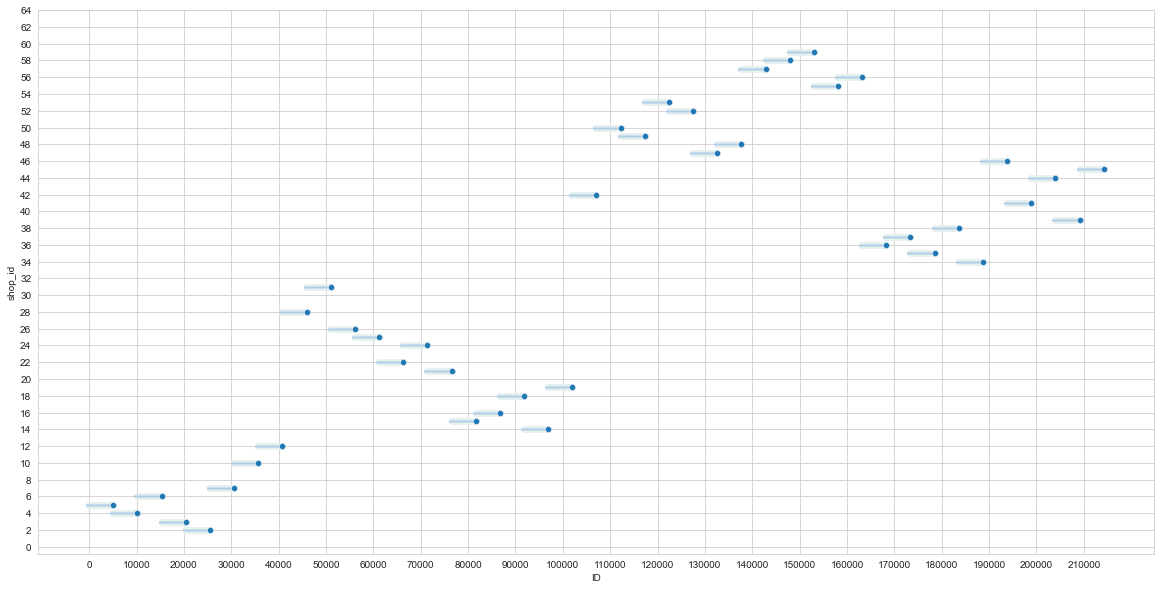

In [ ]:
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
sns.scatterplot(test.ID,test.shop_id)
plt.xticks(range(0,214200,10000));
plt.yticks(range(0,65,2));

Shops appearence in the Test Set are arranged

#### Test set, curiosidades

In [ ]:
#Raro en el Test set --> todos los items se vendieron en TODOS los 42 shops que aparecen
test.groupby("item_id").size().sort_values().unique()

array([42], dtype=int64)

In [ ]:
#Cada Shop aparece 5100 veces...osea, c/shop aparece 1 vez por cada item del Test set
test.groupby("shop_id").size().sort_values()[:10]

shop_id
2     5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
47    5100
dtype: int64

# Dataframe

In [ ]:
df = pd.merge(
    df,
    items[["item_id","item_category_id","major"]],
   on="item_id",
    how="left"
)

df = pd.merge(
    df,
    shops[["shop_id","city"]],
    on="shop_id",
    how="left"
)

In [ ]:
df

date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2936343  10.10.2015              33       25     7409      299.00   
2936344  09.10.2015              33       25     7460      299.00   
2936345  14.10.2015              33       25     7459      349.00   
2936346  22.10.2015              33       25     7440      299.00   
2936347  03.10.2015              33       25     7460      299.00   

         item_cnt_day  item_category_id   major       city  
0                 1.0                37  CINEMA  YAROSLAVL  
1                 1.0                58   MUSIC     MOSCOW  
2                -1.0                58   MUSIC     MOSCOW  
3                 1.0                58   MUSIC     MOSCOW  
4                 1.0                56   MUSIC     MOSCOW  
...               ...               ...     ...        ...  
2936343           1.0                55   MUSIC     MOSCOW  
2936344           1.0                55   MUSIC     MOSCOW  
2936345           1.0                55   MUSIC     MOSCOW  
2936346           1.0                57   MUSIC     MOSCOW  
2936347           1.0                55   MUSIC     MOSCOW  

[2936348 rows x 9 columns]

In [ ]:
#To ease plots readness
df.date = df.date.apply(lambda x: x.split(".")[2] + "-" + x.split(".")[1])
df.date = pd.to_datetime(df["date"])

In [ ]:
test = pd.merge(
    test,
    items[["item_id","item_category_id","major"]],
   on="item_id",
    how="left"
)

test = pd.merge(
    test,
    shops[["shop_id","city"]],
    on="shop_id",
    how="left"
)

In [ ]:
#Creamos una nueva columna con shop_id + item_id, así pasamos el ID al trainset
test["shop_id + item_id"] = test["shop_id"].astype("str") + "_" + test["item_id"].astype("str")
df["shop_id + item_id"] = df["shop_id"].astype("str") + "_" + df["item_id"].astype("str")
test["shop_id + categ"] = test["shop_id"].astype("str") + "_" + test["item_category_id"].astype("str")
df["shop_id + categ"] = df["shop_id"].astype("str") + "_" + df["item_category_id"].astype("str")

#df = pd.merge(
#    df,
#    test[["ID","shop_id + item_id"]],
#    on="shop_id + item_id",
#    how="left"
#)
#df.ID.fillna(-9999,inplace=True)

In [ ]:
def shop_Item_Only_In_Test(x):
    
    not_concurrence = []
    if x not in df["shop_id + categ"].unique():
        return x
    else:
        return "-"

In [ ]:
#shopItemOnlyInTest = pd.DataFrame({"not_concurrence":[]})
#shopItemOnlyInTest["not_concurrence"] = pd.Series(test["shop_id + categ"].unique()).apply(lambda x: shop_Item_Only_In_Test(x))

In [ ]:
#shopItemOnlyInTest[shopItemOnlyInTest.not_concurrence!="-"].to_csv("not_ocurrences.csv")
shopItemOnlyInTest = pd.read_csv("not_ocurrences.csv")

In [ ]:
#a = df.groupby(["shop_id + item_id","date_block_num"]).mean()[["item_cnt_day"]].reset_index()

In [ ]:
#pd.crosstab(a.date_block_num, a["shop_id + item_id"], values=a.item_cnt_day, aggfunc=np.mean(a))

In [ ]:
#pd.crosstab?

# Monthly

In [ ]:
df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-01               0       59    22154      999.00           1.0   
1 2013-01-01               0       25     2552      899.00           1.0   
2 2013-01-01               0       25     2552      899.00          -1.0   
3 2013-01-01               0       25     2554     1709.05           1.0   
4 2013-01-01               0       25     2555     1099.00           1.0   

   item_category_id   major       city shop_id + item_id shop_id + categ  
0                37  CINEMA  YAROSLAVL          59_22154           59_37  
1                58   MUSIC     MOSCOW           25_2552           25_58  
2                58   MUSIC     MOSCOW           25_2552           25_58  
3                58   MUSIC     MOSCOW           25_2554           25_58  
4                56   MUSIC     MOSCOW           25_2555           25_56

In [ ]:
monthly = df.groupby(["date_block_num","shop_id","item_id","item_category_id",\
                     "major","city",'shop_id + item_id','shop_id + categ']).agg({"item_price":"mean","item_cnt_day":"sum"}).reset_index()

In [ ]:
monthly.head()

date_block_num  shop_id  item_id  item_category_id   major     city  \
0               0        0       32                40  CINEMA  YAKUTSK   
1               0        0       33                37  CINEMA  YAKUTSK   
2               0        0       35                40  CINEMA  YAKUTSK   
3               0        0       43                40  CINEMA  YAKUTSK   
4               0        0       51                57   MUSIC  YAKUTSK   

  shop_id + item_id shop_id + categ  item_price  item_cnt_day  
0              0_32            0_40       221.0           6.0  
1              0_33            0_37       347.0           3.0  
2              0_35            0_40       247.0           1.0  
3              0_43            0_40       221.0           1.0  
4              0_51            0_57       128.5           2.0

In [ ]:
monthly.item_cnt_day

0          6.0
1          3.0
2          1.0
3          1.0
4          2.0
          ... 
1594202    6.0
1594203    2.0
1594204    1.0
1594205    1.0
1594206    1.0
Name: item_cnt_day, Length: 1594207, dtype: float64

In [ ]:
for x in monthly.columns:
    plt.figure(figsize=(20,6))
    sns.scatterplot(monthly.index,monthly[x], hue=monthly.item_cnt_day)

Categories 8,9,31,34,54,61,76 and 80 --> tends to buy much more in "OTHERS" (include online buy)

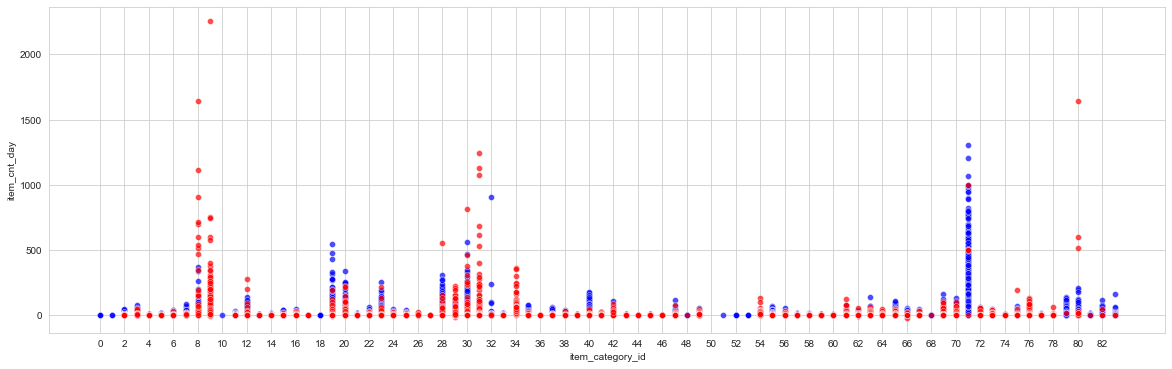

In [ ]:
a = monthly[monthly["city"]!="OTHER"]
b = monthly[monthly["city"]=="OTHER"]
plt.figure(figsize=(20,6))
sns.scatterplot(a.item_category_id,a["item_cnt_day"], color="blue", alpha=0.7)
sns.scatterplot(b.item_category_id,b["item_cnt_day"], color="red", alpha=0.7)
plt.xticks(range(0,monthly.item_category_id.nunique(),2));

It makes all sense as this categories are (most of them) remote

In [ ]:
items_cat[items_cat["item_category_id"].isin([8,9,31,34,54,61,76,80])]

item_category_name  item_category_id     major
8                          Tickets (digit)                 8   TICKETS
9                        Delivery of goods                 9    OTHERS
31                        PC games - digit                31   PCGAMES
34         Payment cards - Live! (Numeral)                34   PAYMENT
54                           Books - digit                54     BOOKS
61                      Gifts - attributes                61     GIFTS
76  Programs - for home and office (digit)                76  PROGRAMS
80                       Service - Tickets                80   TICKETS

In [ ]:
items_cat[items_cat["item_category_id"]==40]

item_category_name  item_category_id   major
40      Cinema - DVD.                40  CINEMA

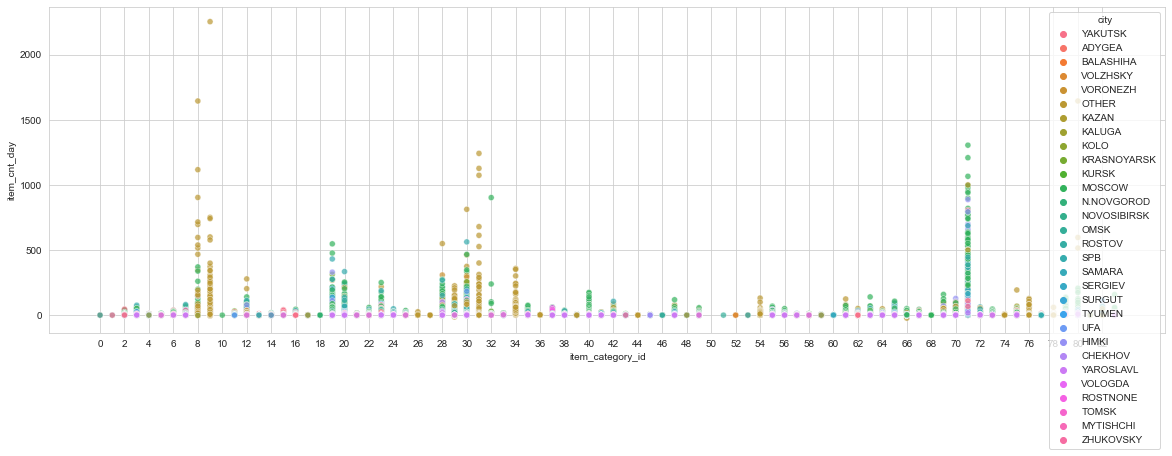

In [ ]:
plt.figure(figsize=(20,6))
sns.scatterplot(monthly.item_category_id,monthly["item_cnt_day"], color="blue", alpha=0.7, hue=monthly.city)
plt.xticks(range(0,monthly.item_category_id.nunique(),2));

In [ ]:
monthly.head()

date_block_num  shop_id  item_id  item_category_id   major     city  \
0               0        0       32                40  CINEMA  YAKUTSK   
1               0        0       33                37  CINEMA  YAKUTSK   
2               0        0       35                40  CINEMA  YAKUTSK   
3               0        0       43                40  CINEMA  YAKUTSK   
4               0        0       51                57   MUSIC  YAKUTSK   

  shop_id + item_id shop_id + categ  item_price  item_cnt_day  
0              0_32            0_40       221.0           6.0  
1              0_33            0_37       347.0           3.0  
2              0_35            0_40       247.0           1.0  
3              0_43            0_40       221.0           1.0  
4              0_51            0_57       128.5           2.0

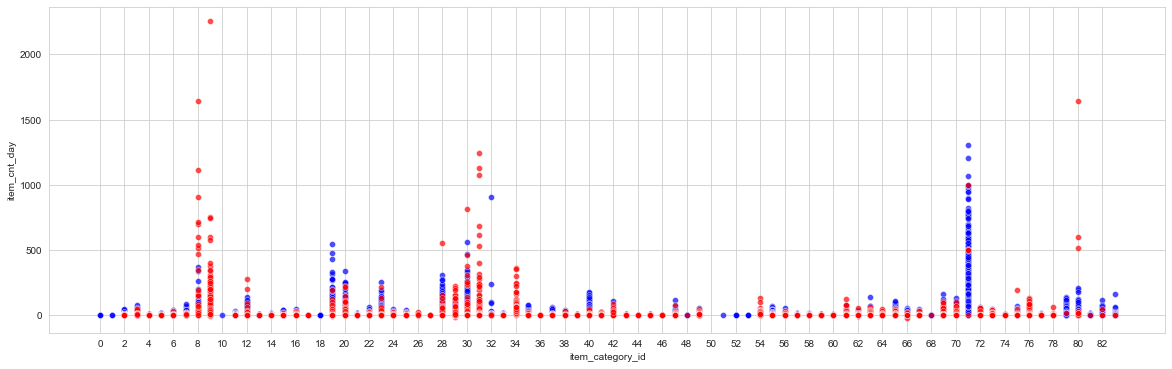

In [ ]:
a = monthly[monthly["city"]!="OTHER"]
b = monthly[monthly["city"]=="OTHER"]
plt.figure(figsize=(20,6))
sns.scatterplot(a.item_category_id,a["item_cnt_day"], color="blue", alpha=0.7)
sns.scatterplot(b.item_category_id,b["item_cnt_day"], color="red", alpha=0.7)
plt.xticks(range(0,monthly.item_category_id.nunique(),2));

In [ ]:
CategoriesByCities = monthly.groupby(["item_category_id","city"]).mean().item_cnt_day.reset_index()

In [ ]:
CategoriesByCities

item_category_id       city  item_cnt_day
0                    0     MOSCOW      1.000000
1                    0       OMSK      1.000000
2                    0    YAKUTSK      1.000000
3                    1     SAMARA      1.000000
4                    1    YAKUTSK      1.000000
...                ...        ...           ...
1798                83    VOLOGDA      3.000000
1799                83   VOLZHSKY      2.058824
1800                83   VORONEZH      5.819444
1801                83    YAKUTSK      6.666667
1802                83  YAROSLAVL      5.037736

[1803 rows x 3 columns]

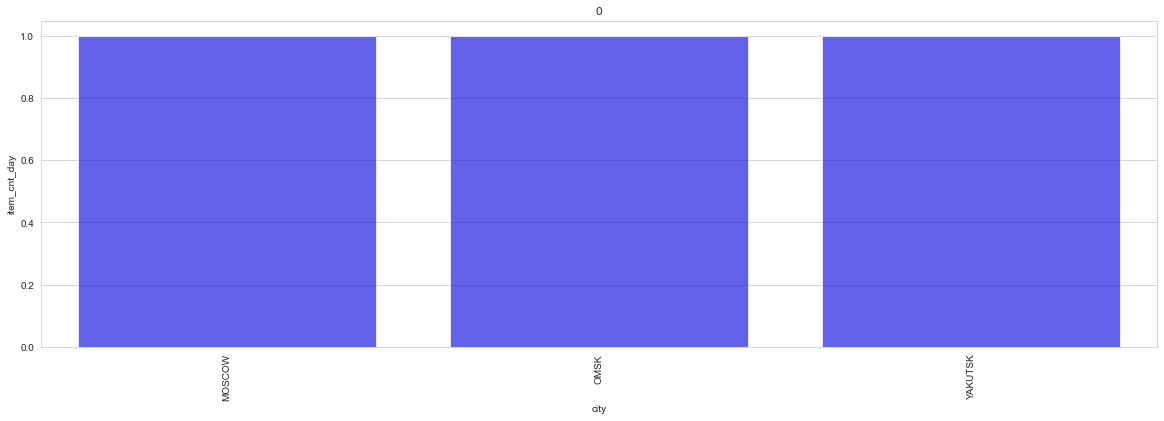

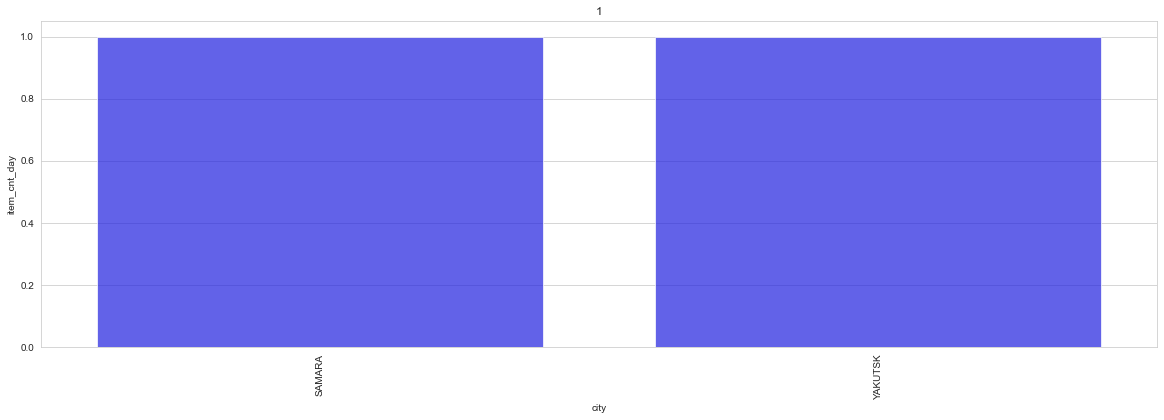

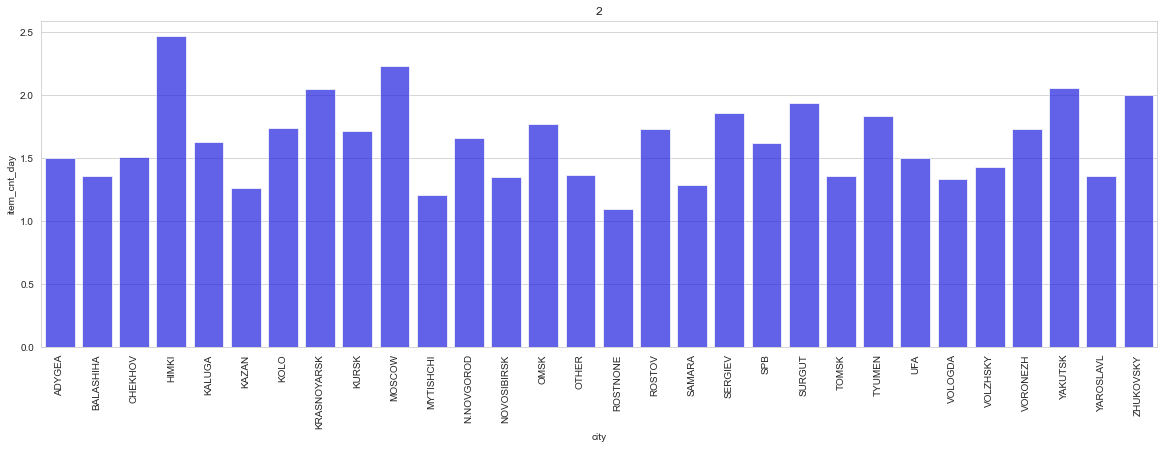

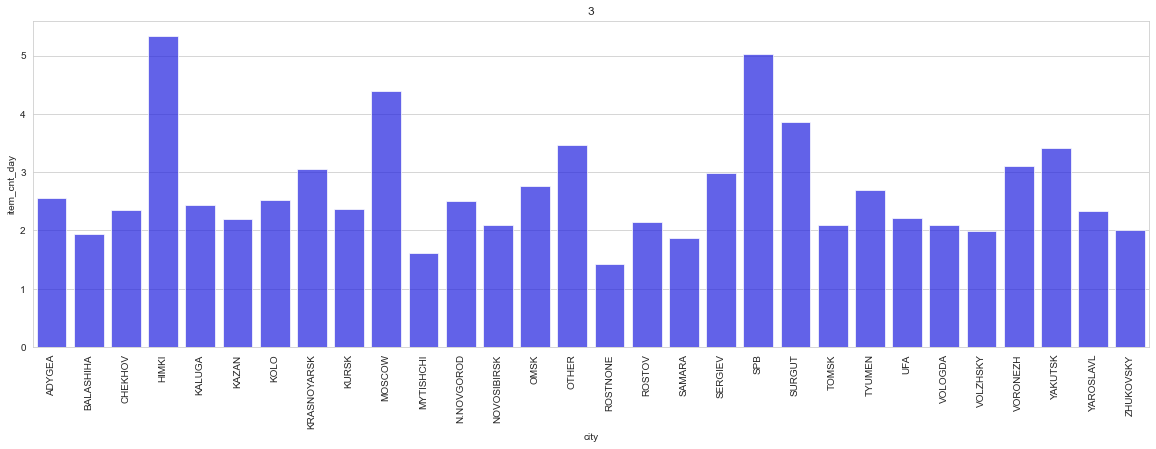

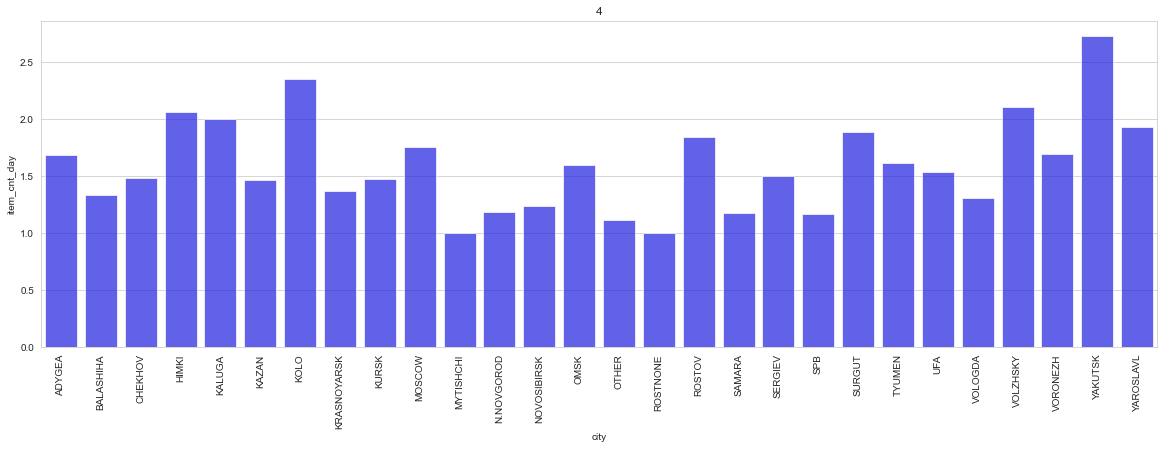

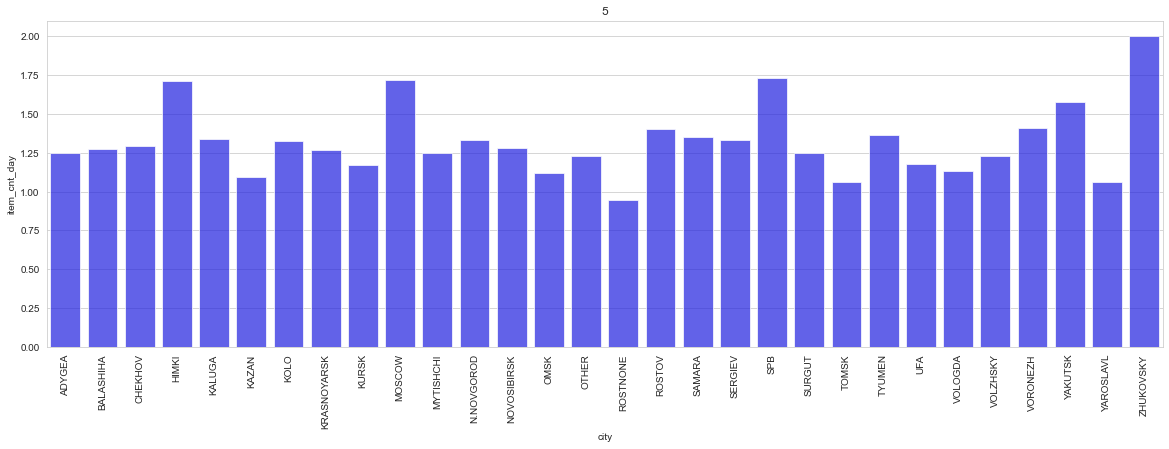

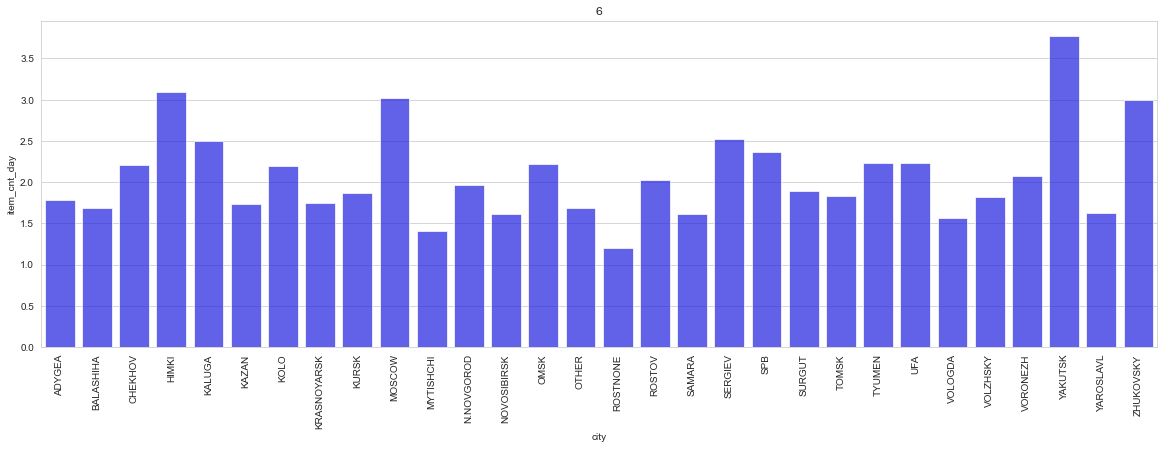

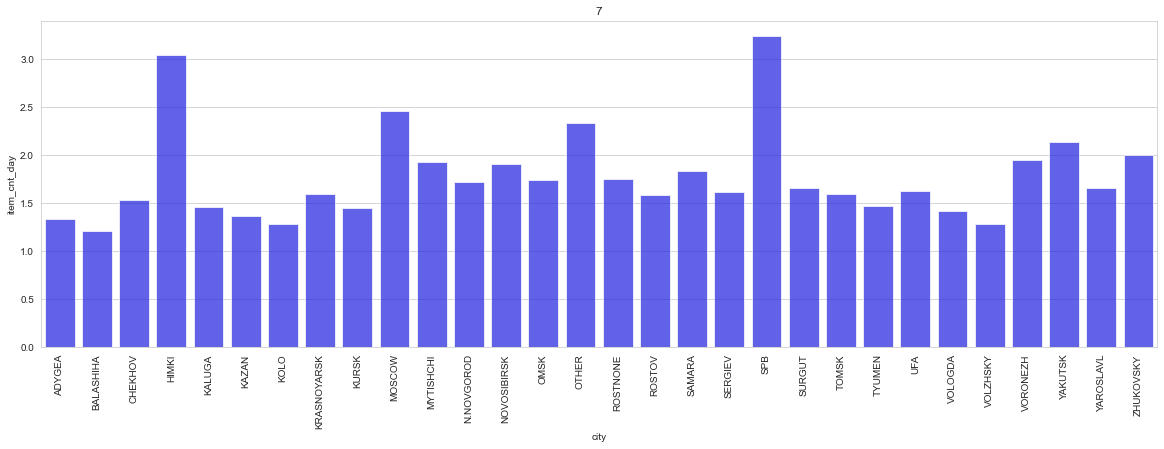

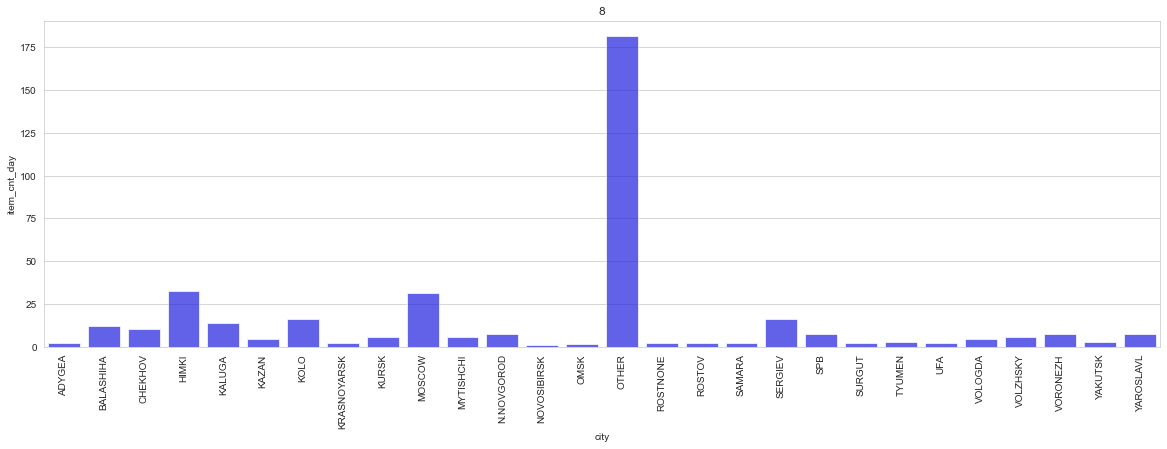

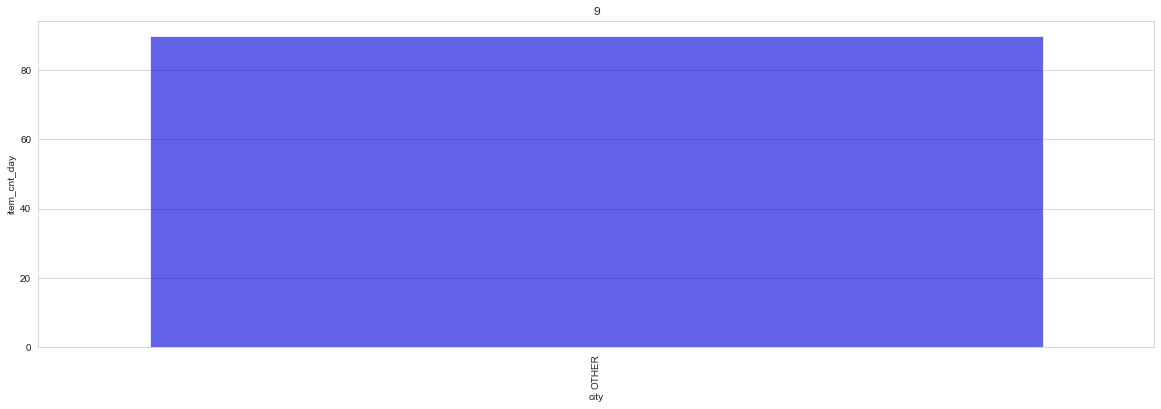

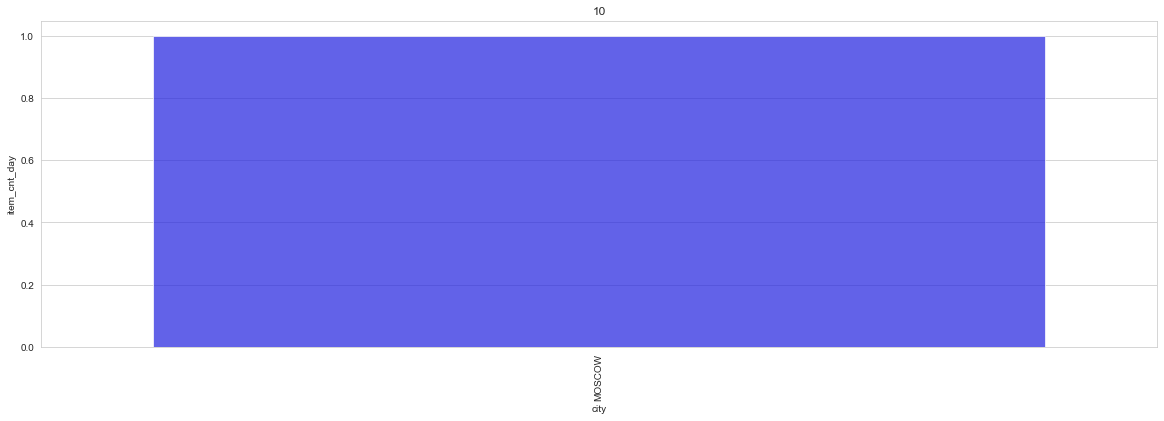

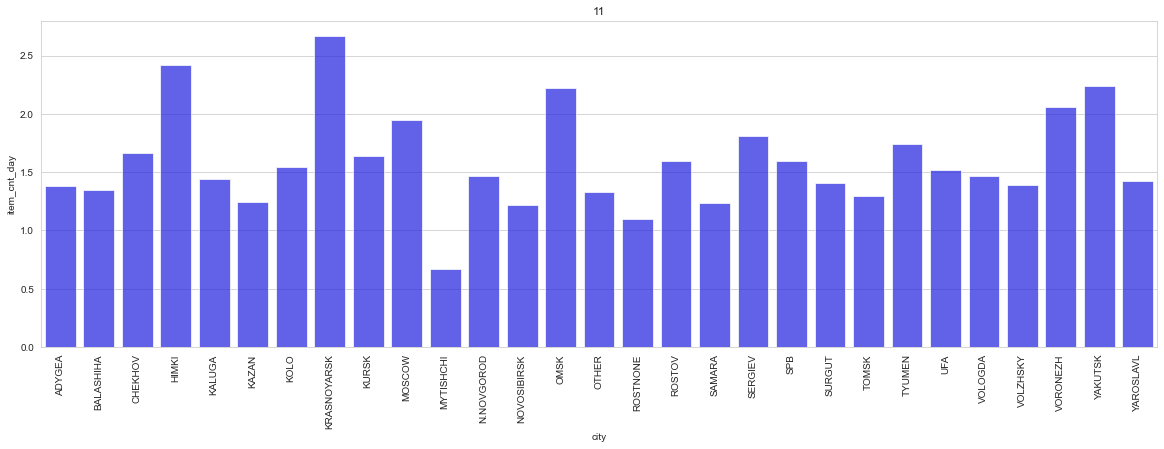

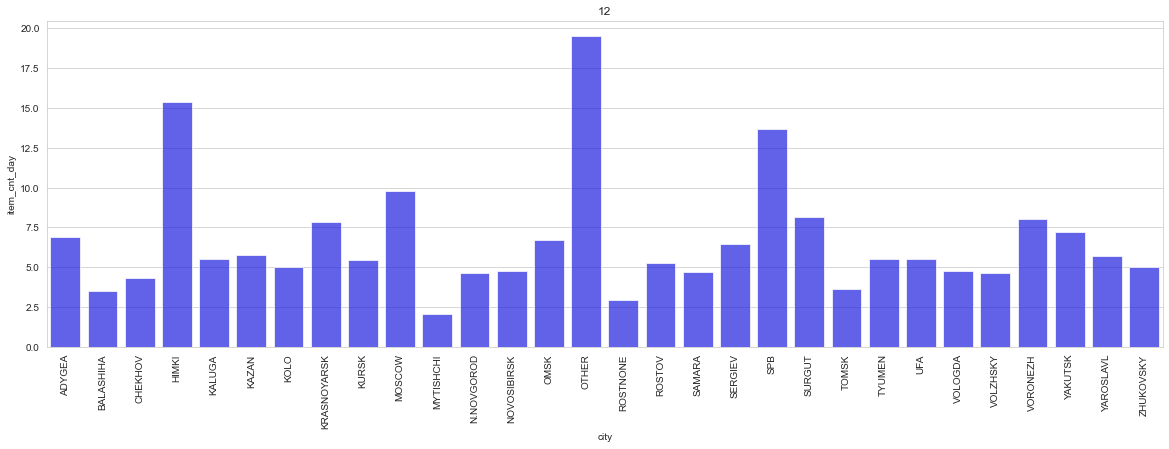

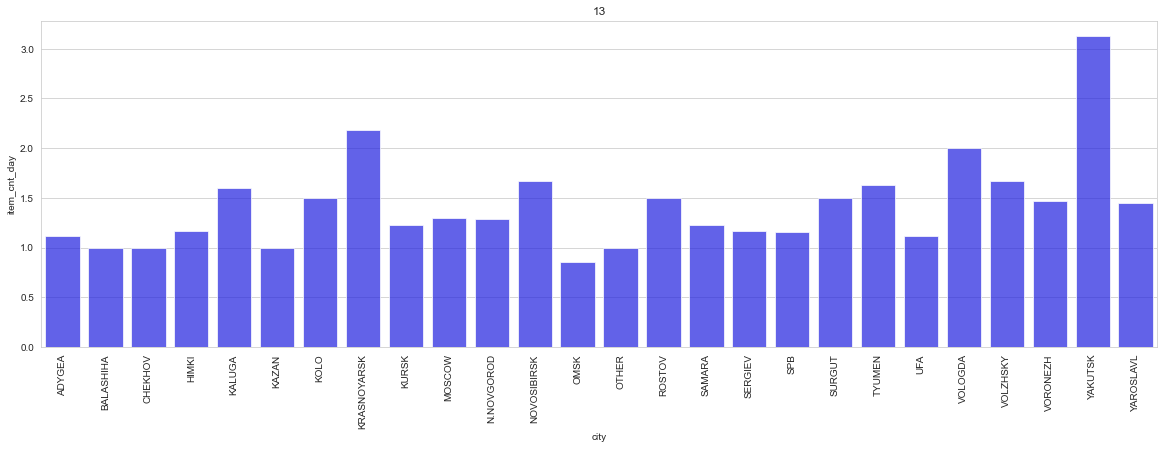

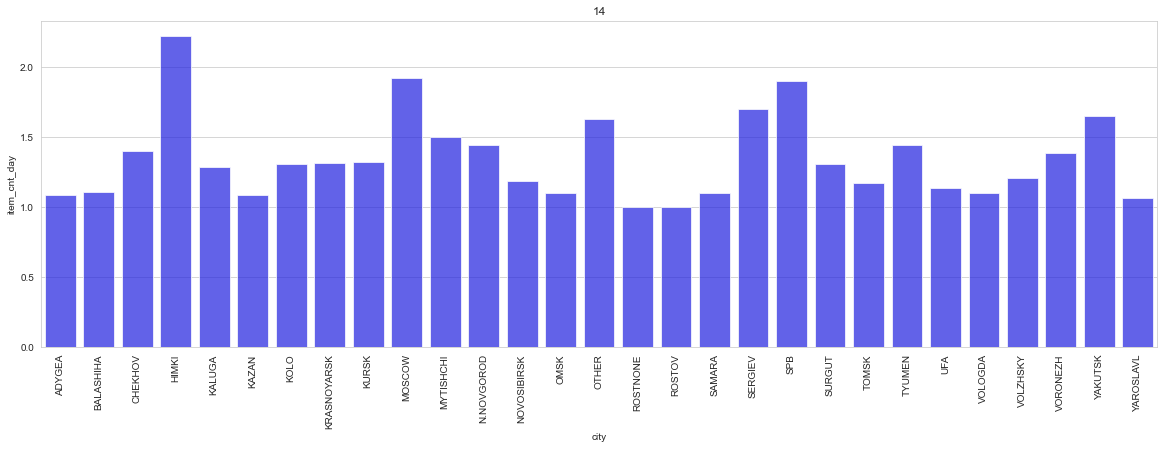

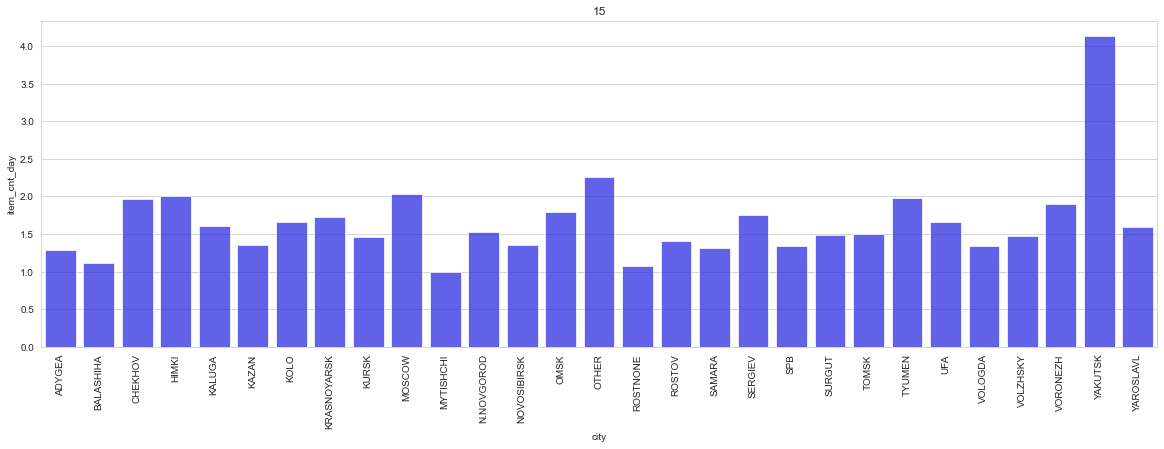

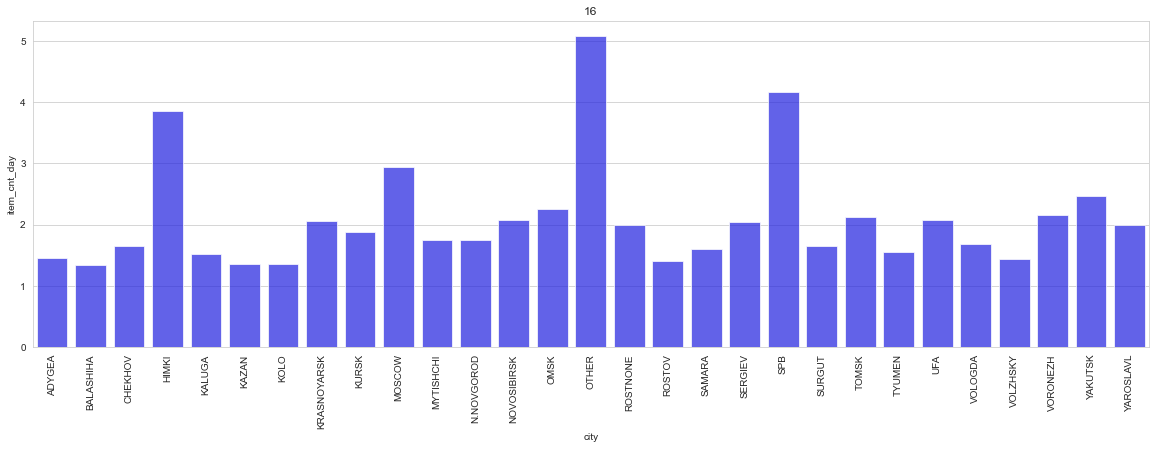

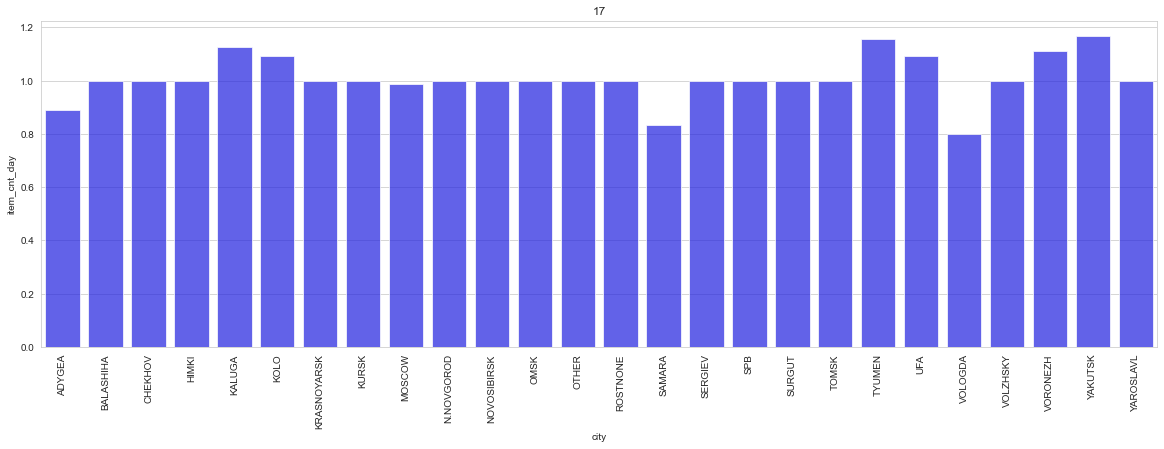

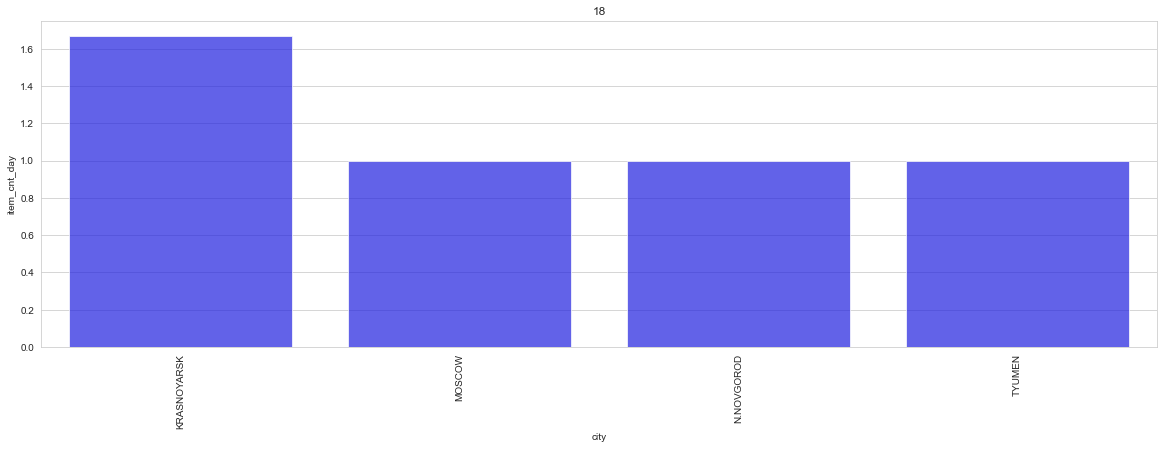

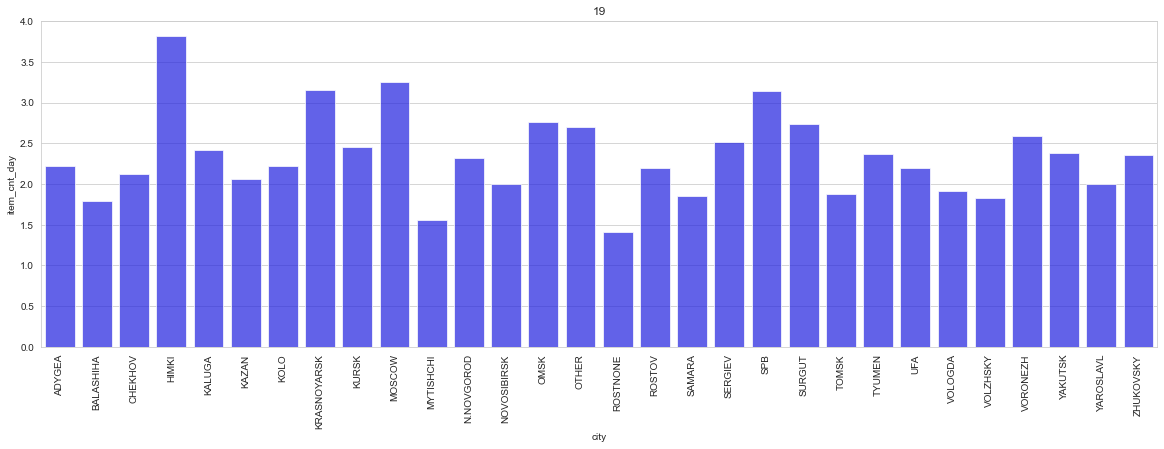

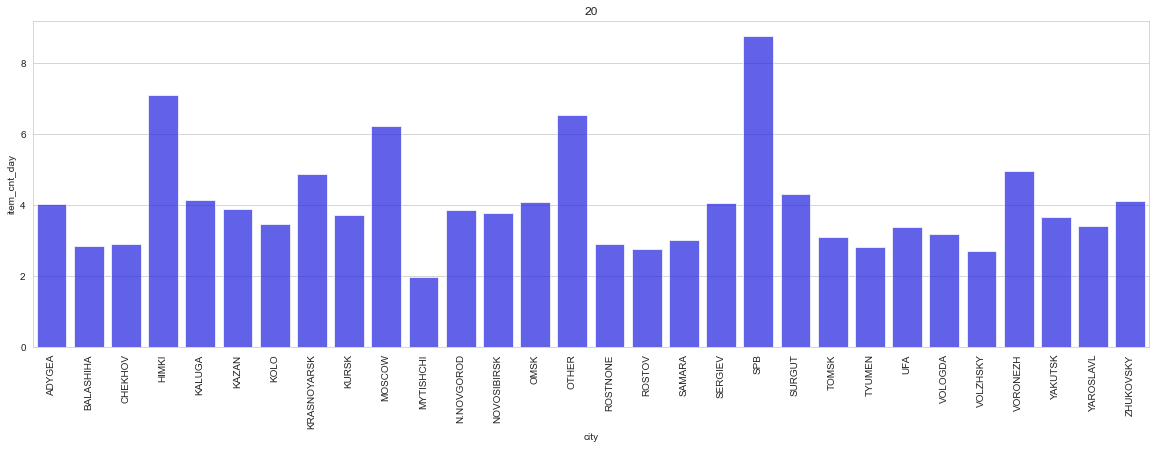

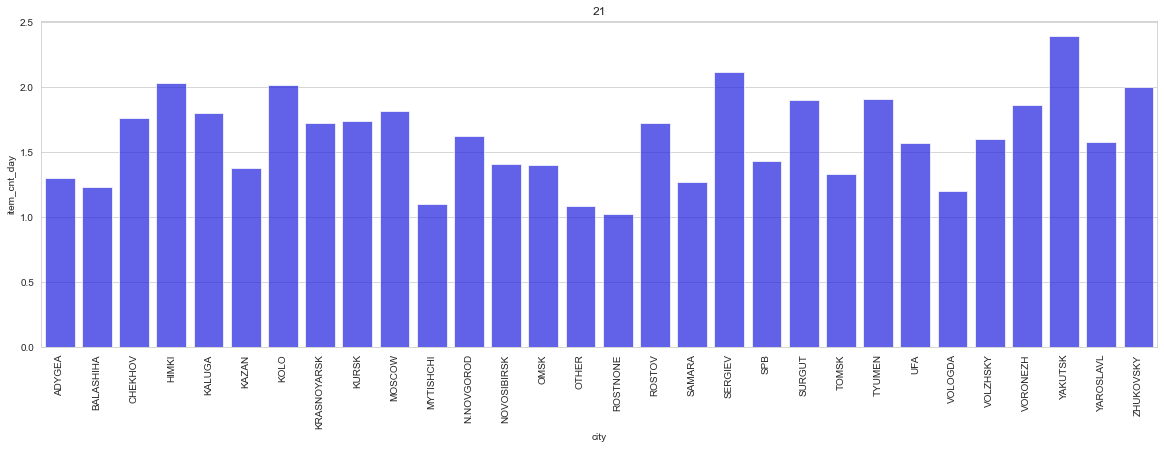

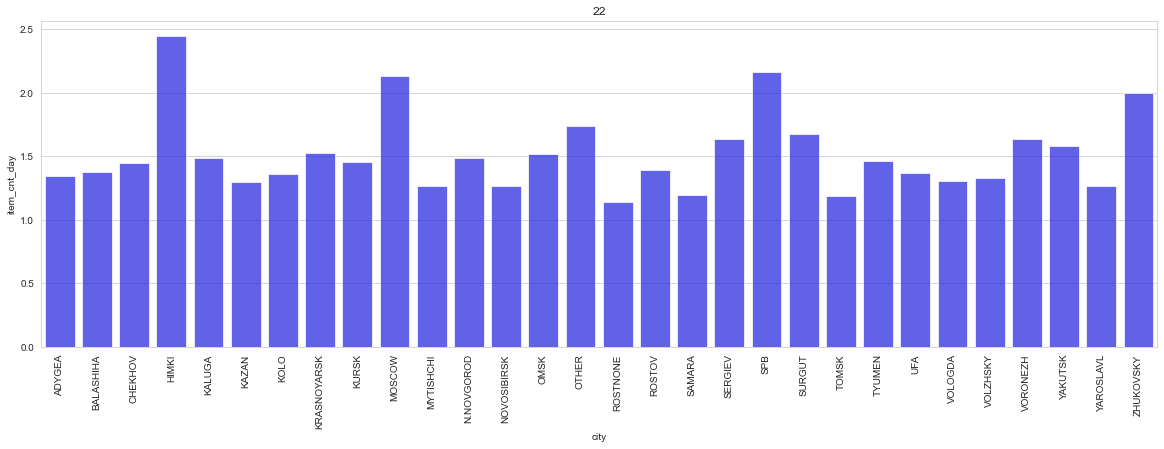

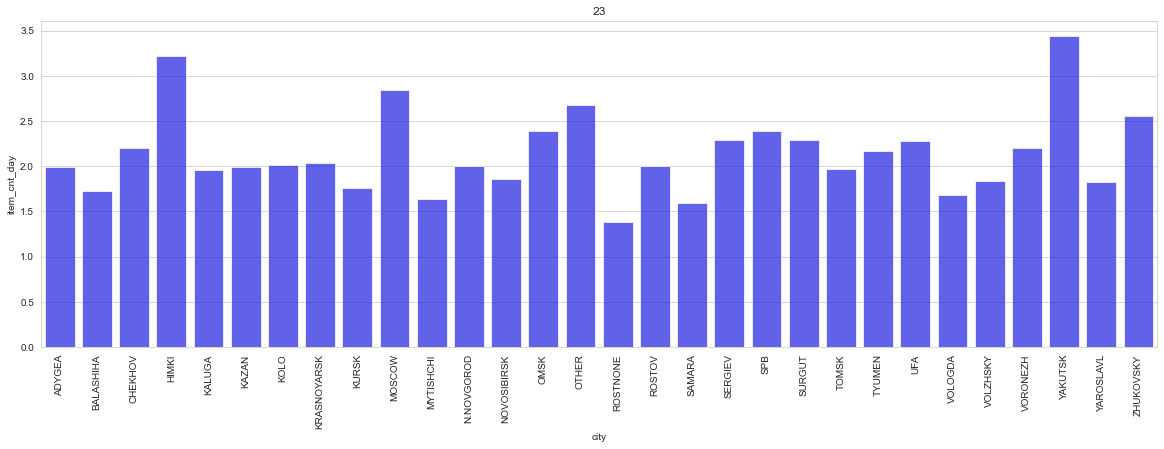

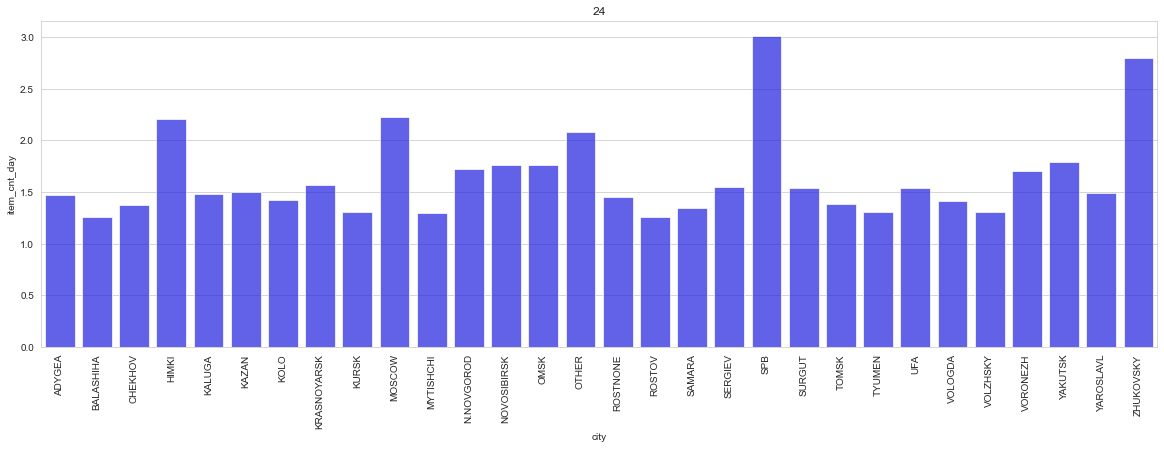

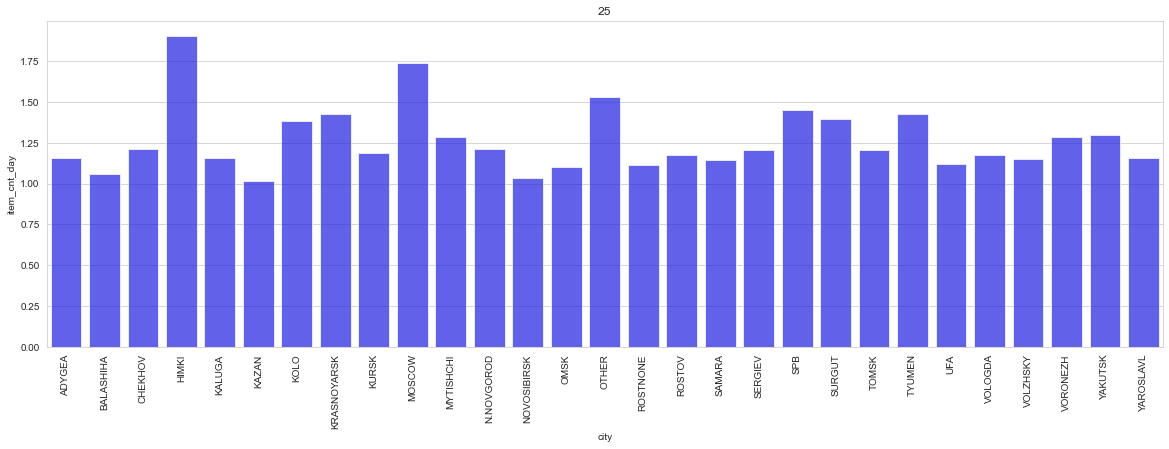

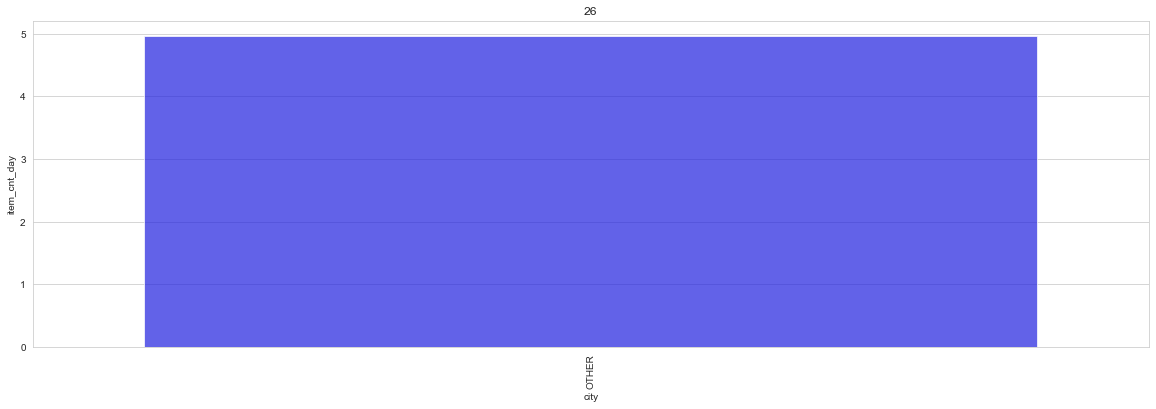

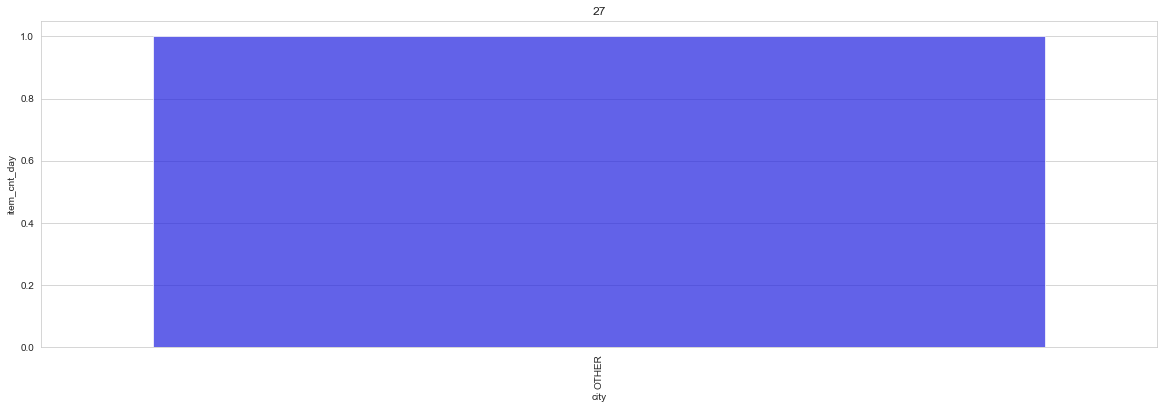

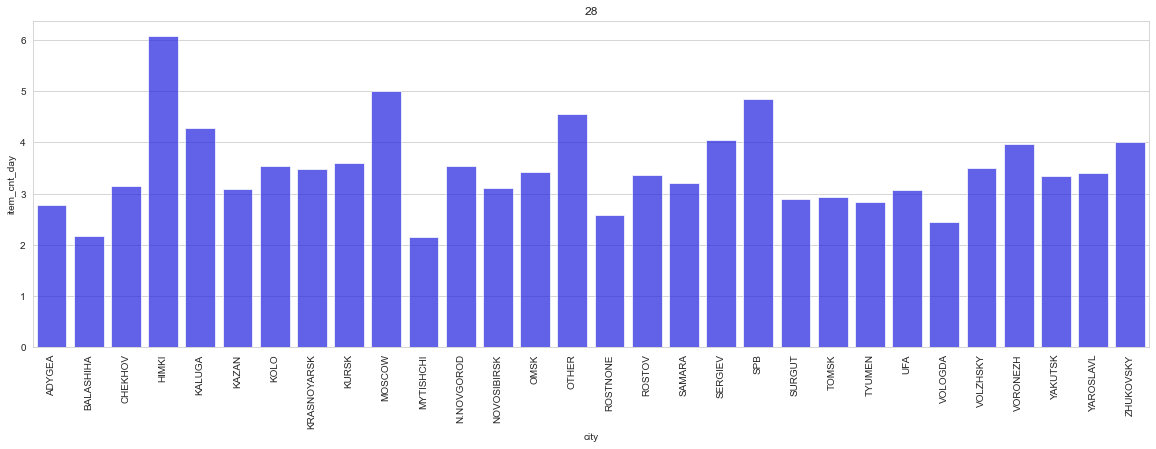

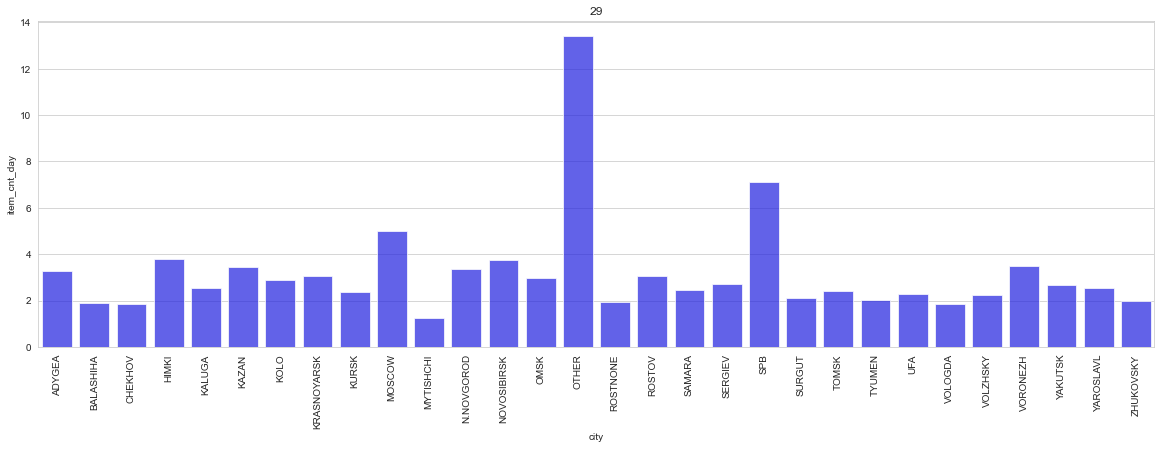

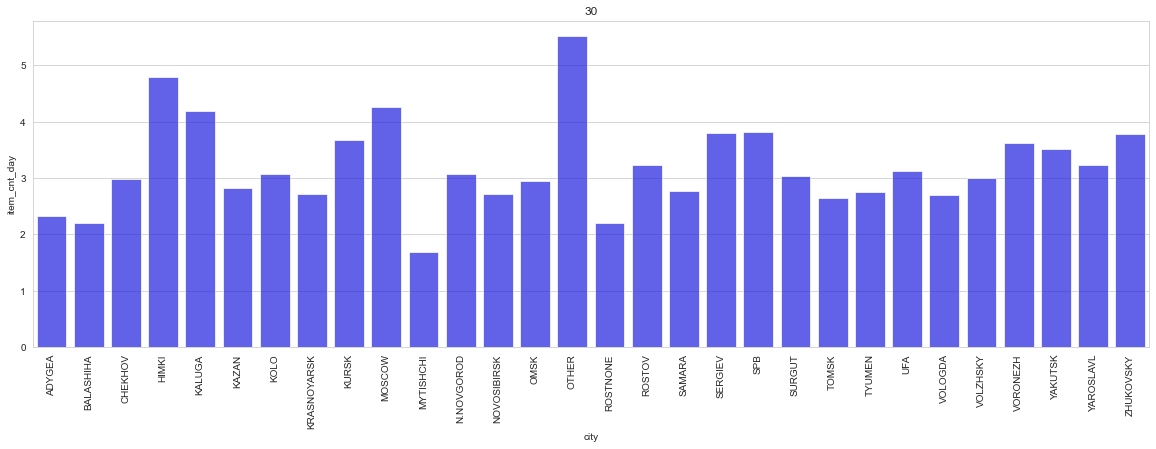

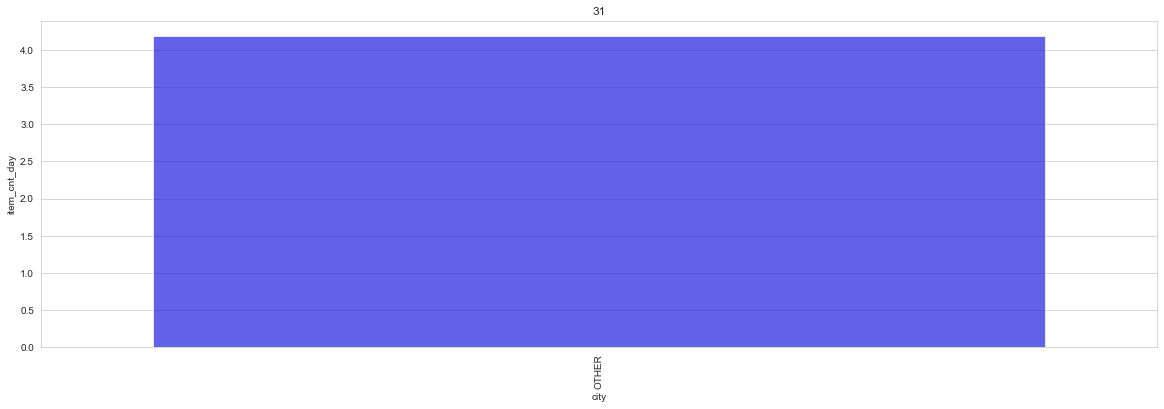

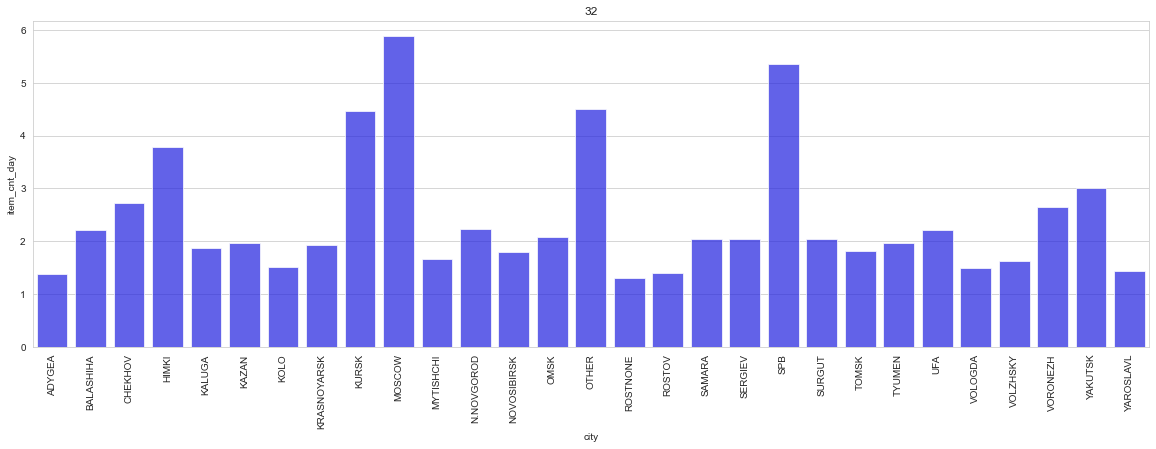

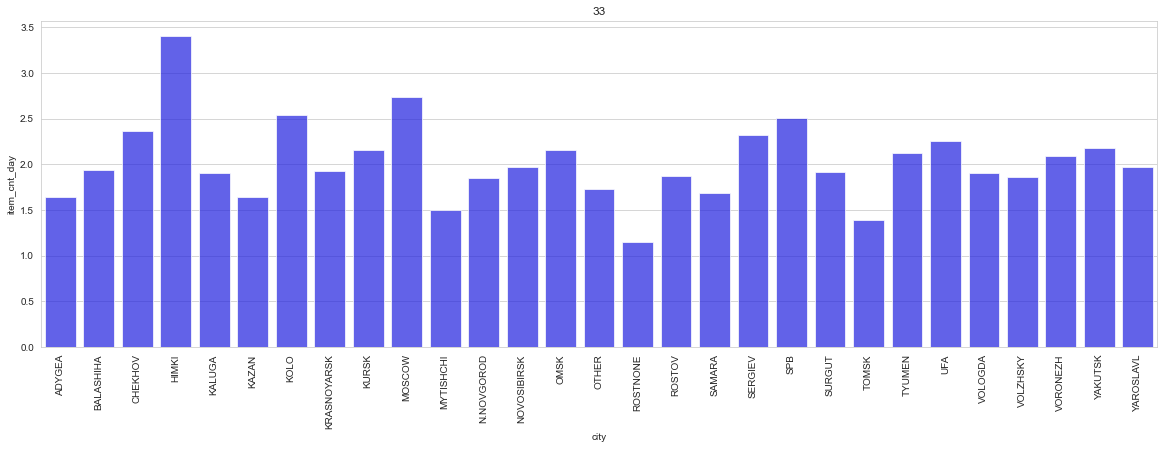

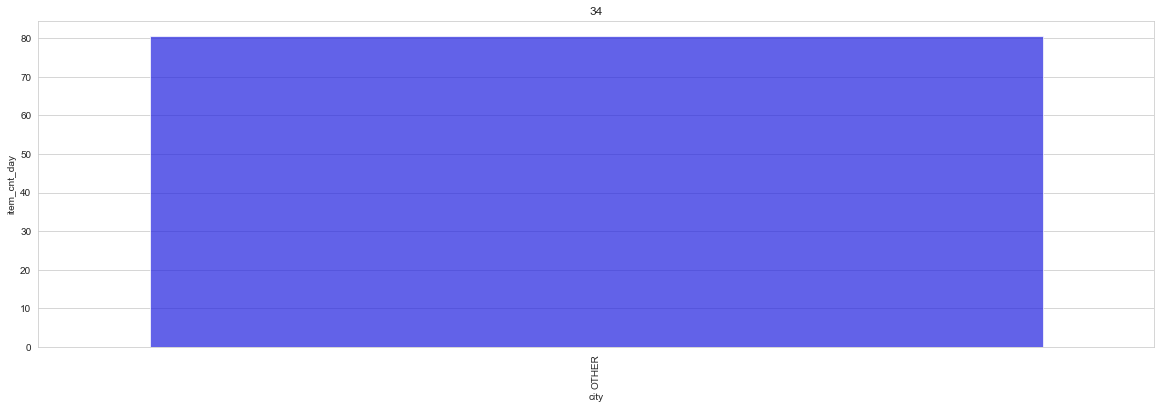

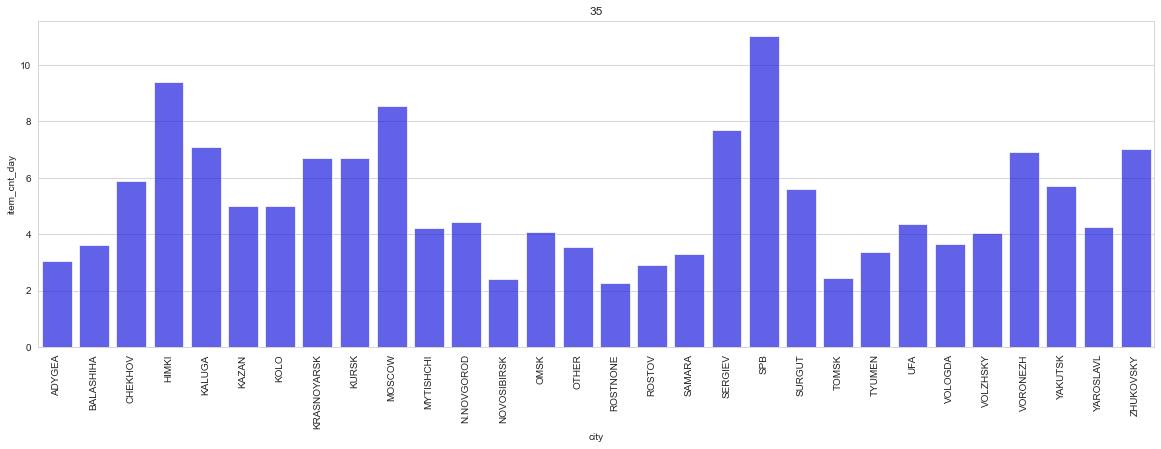

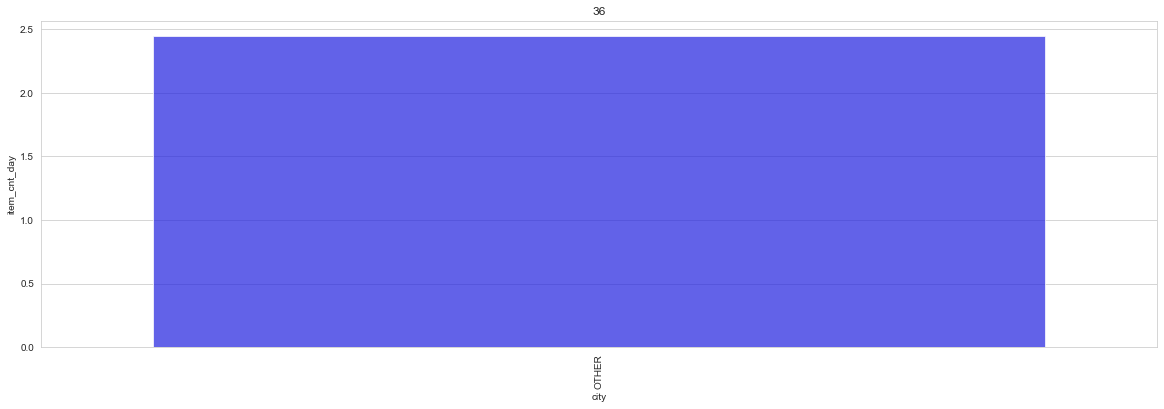

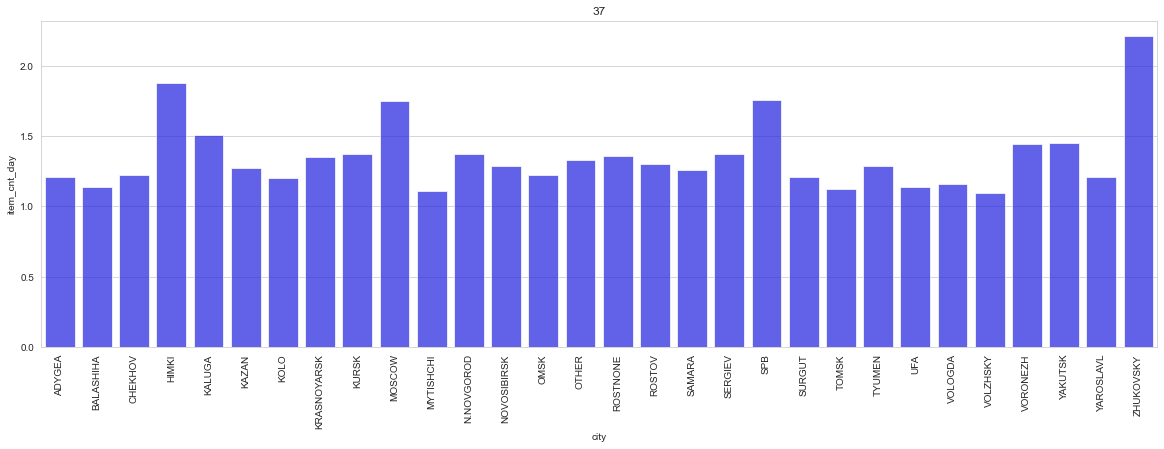

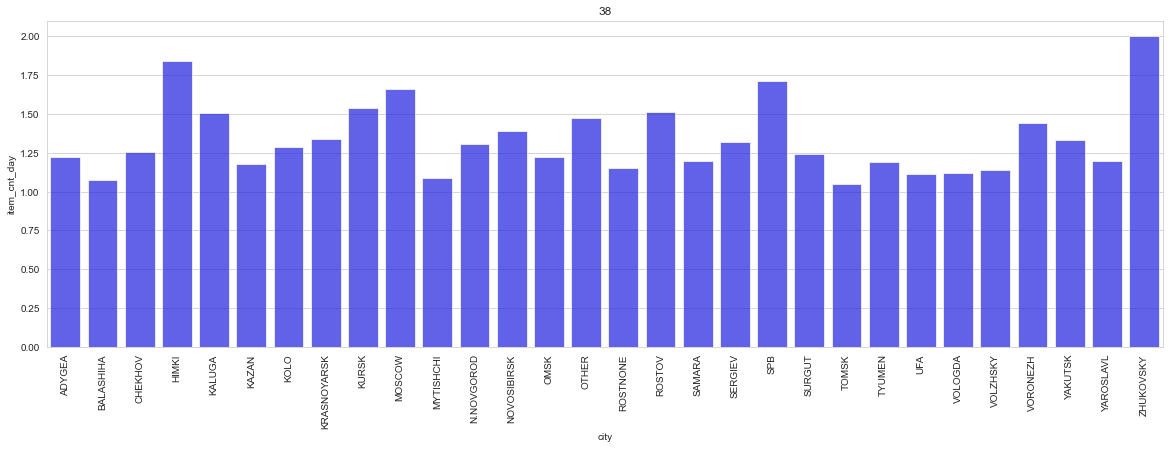

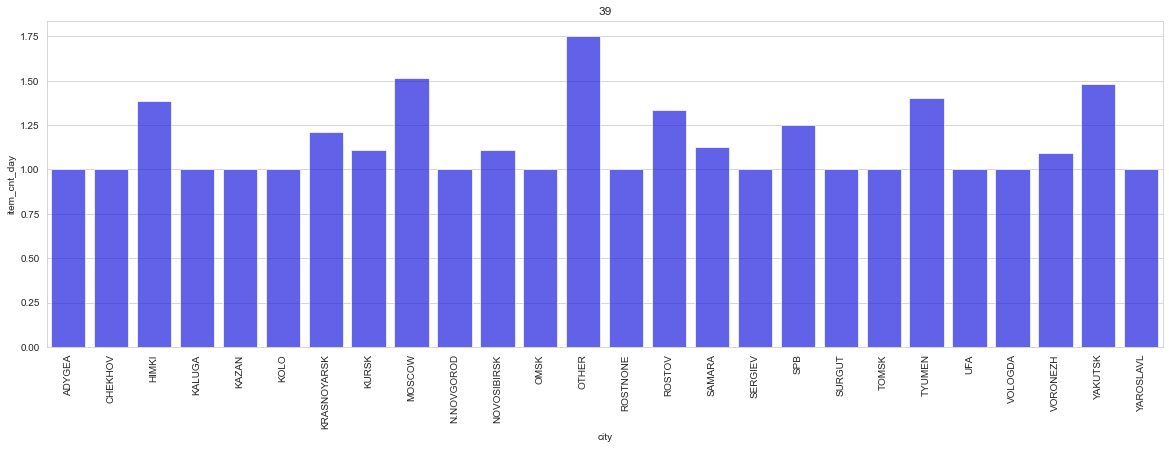

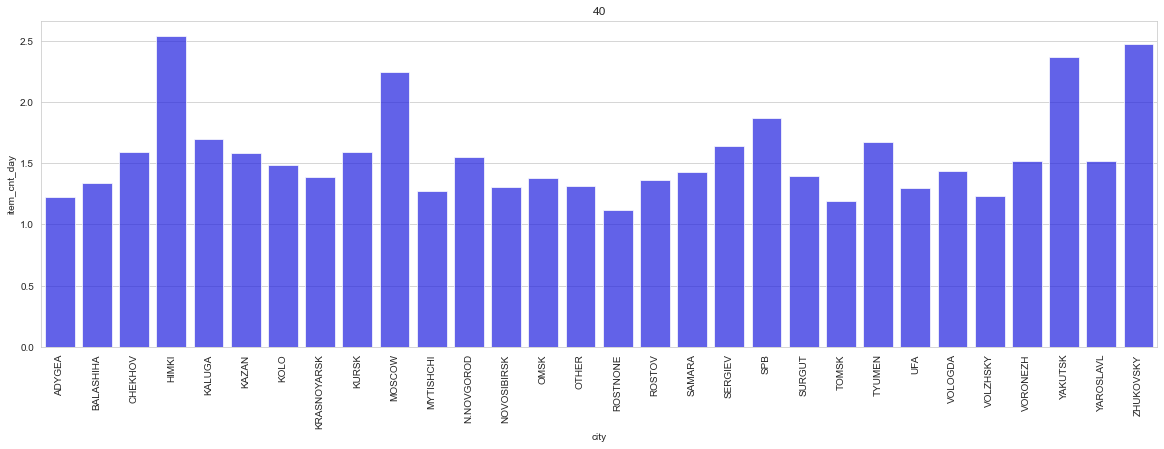

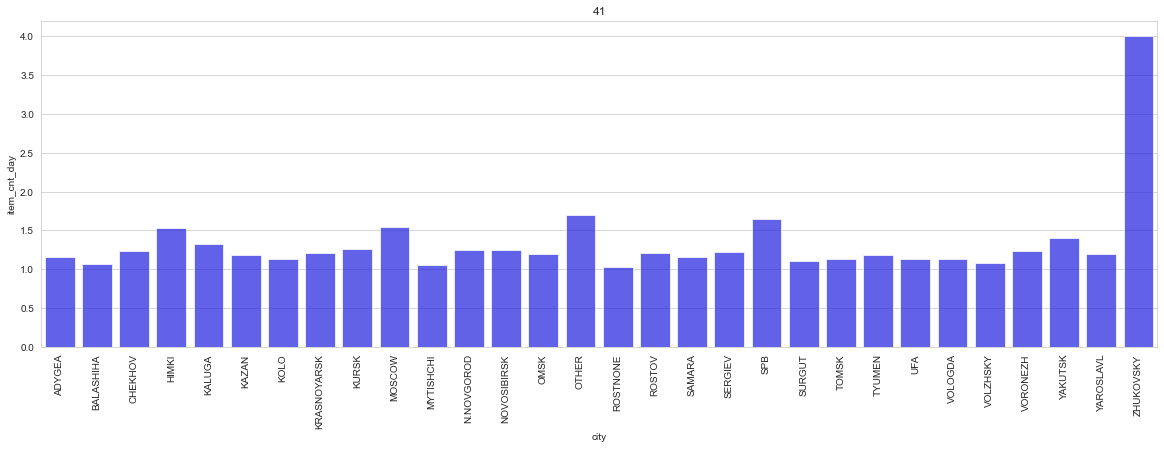

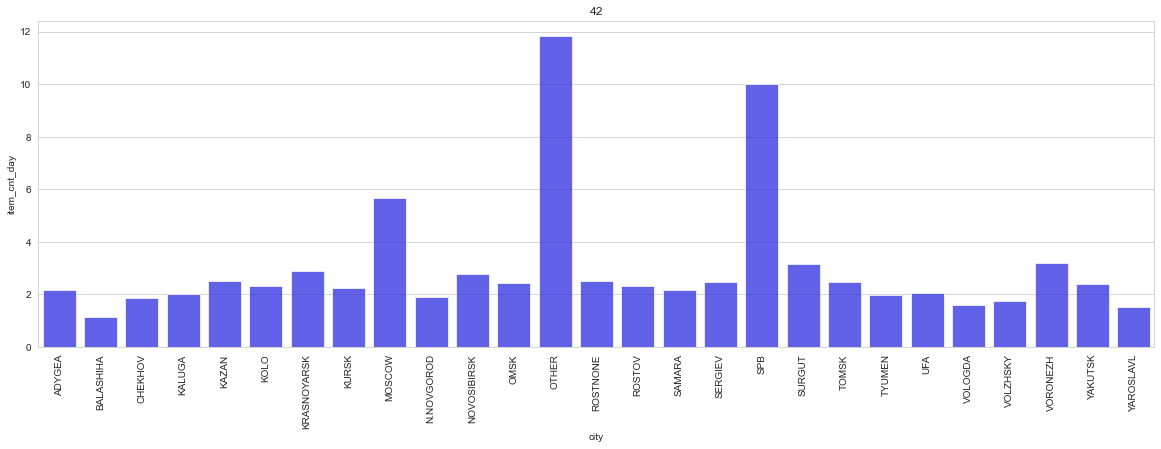

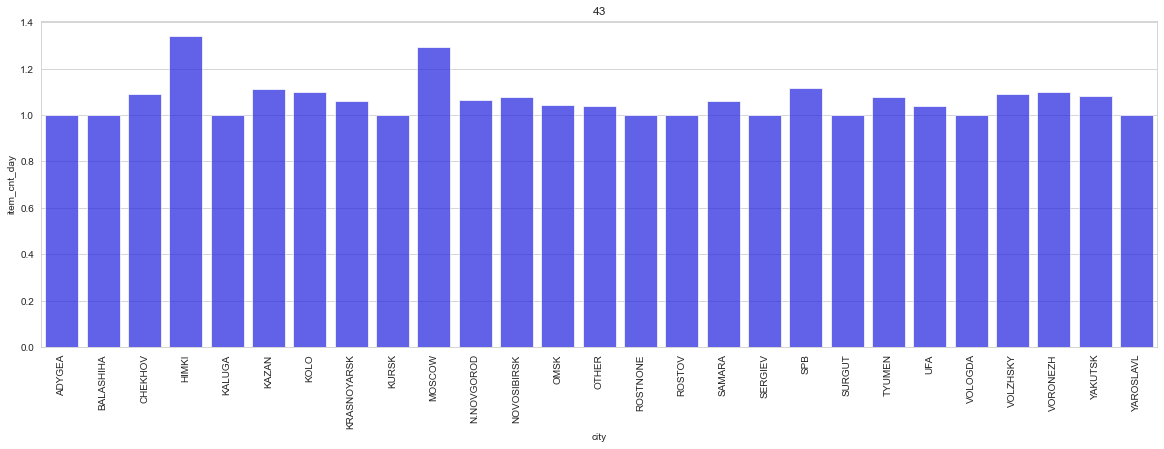

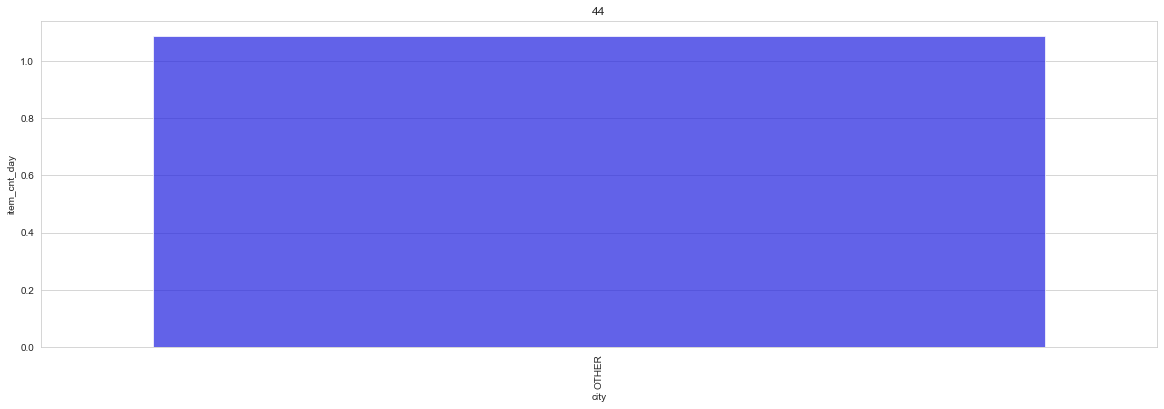

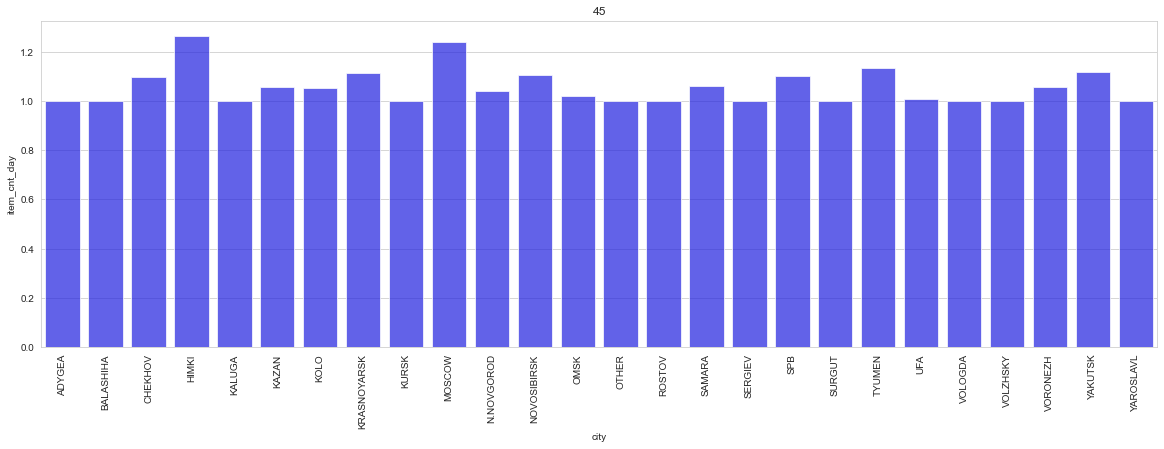

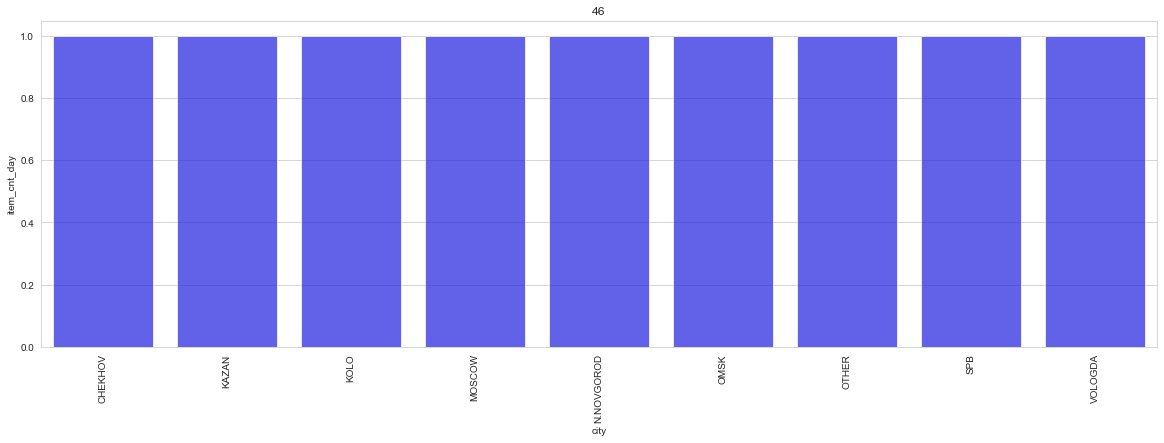

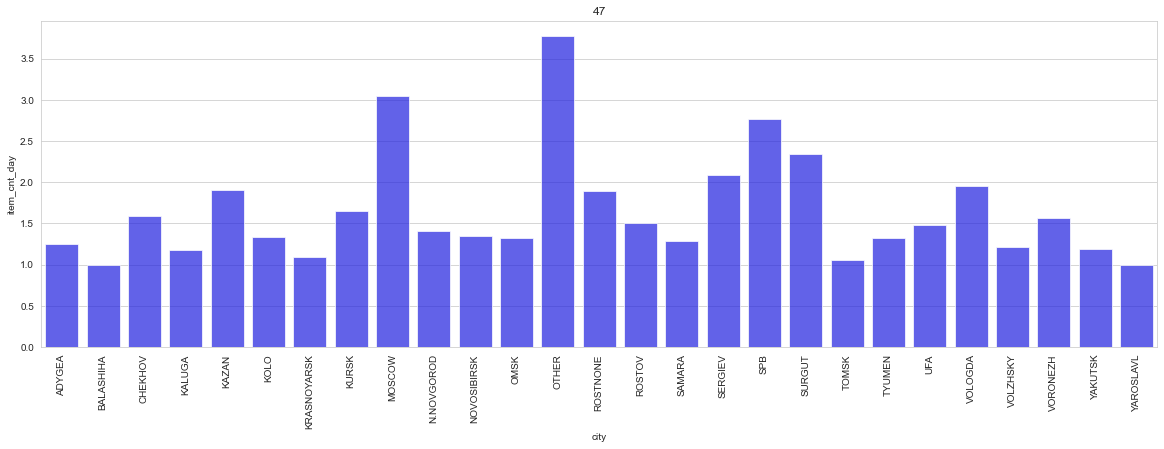

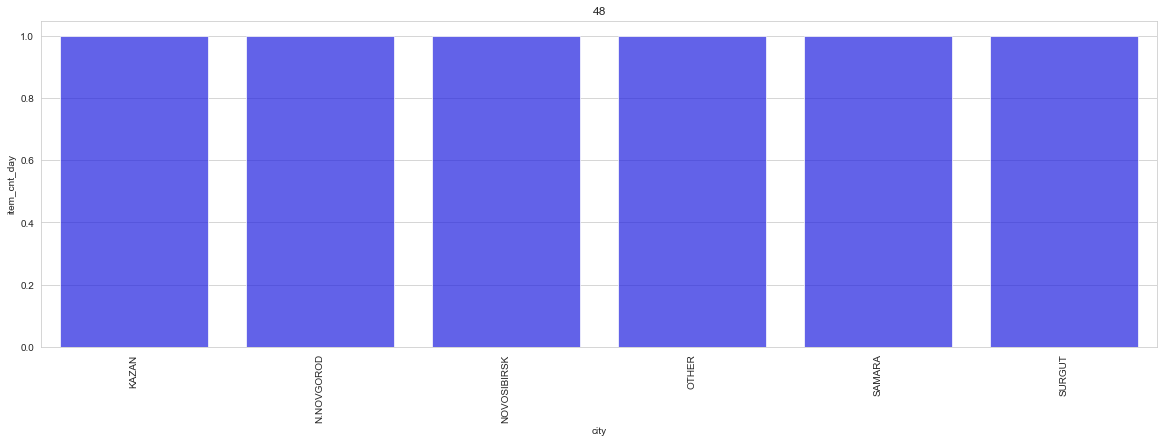

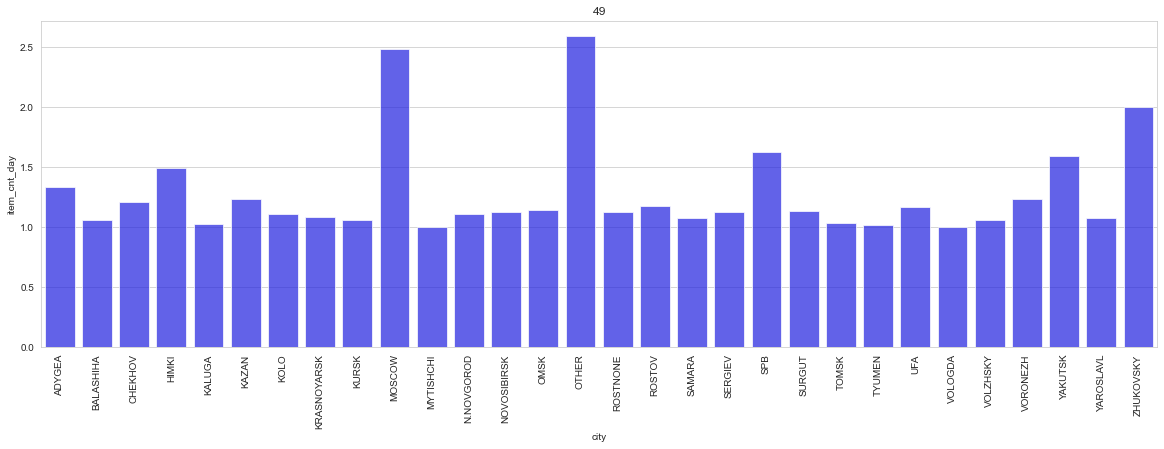

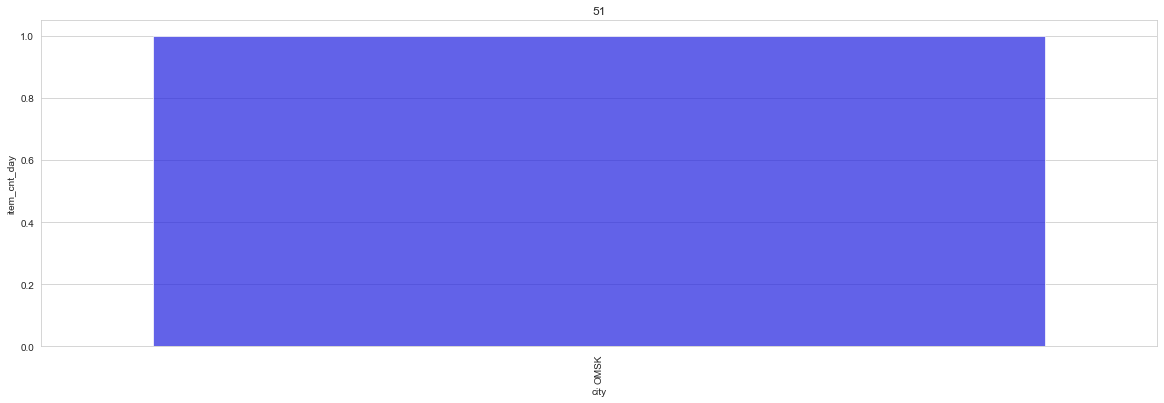

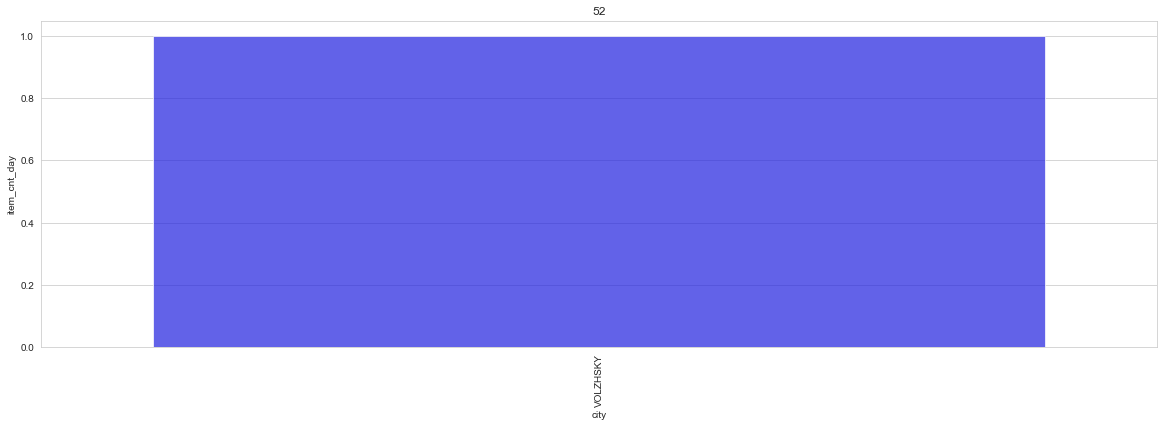

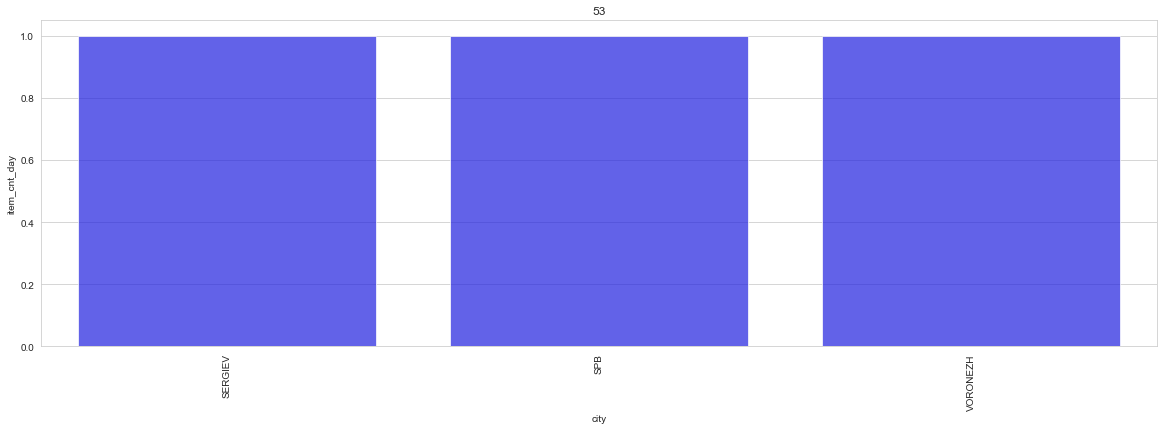

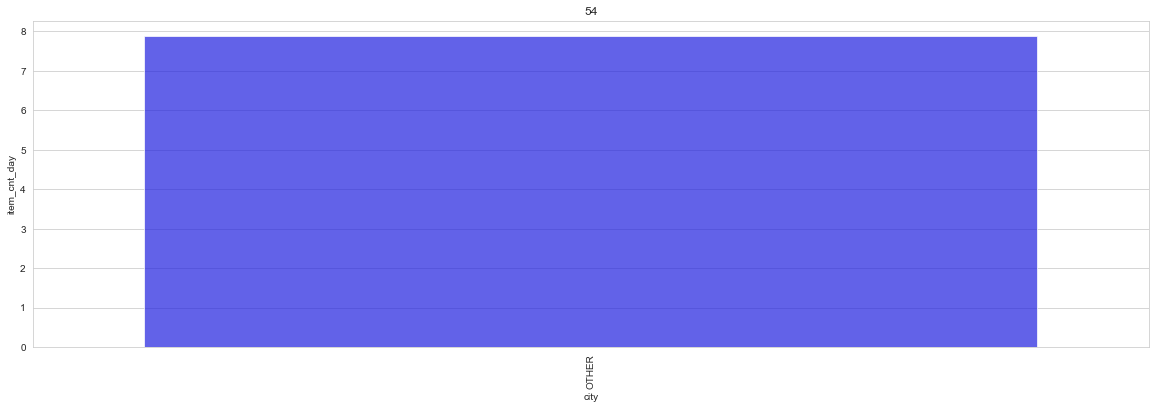

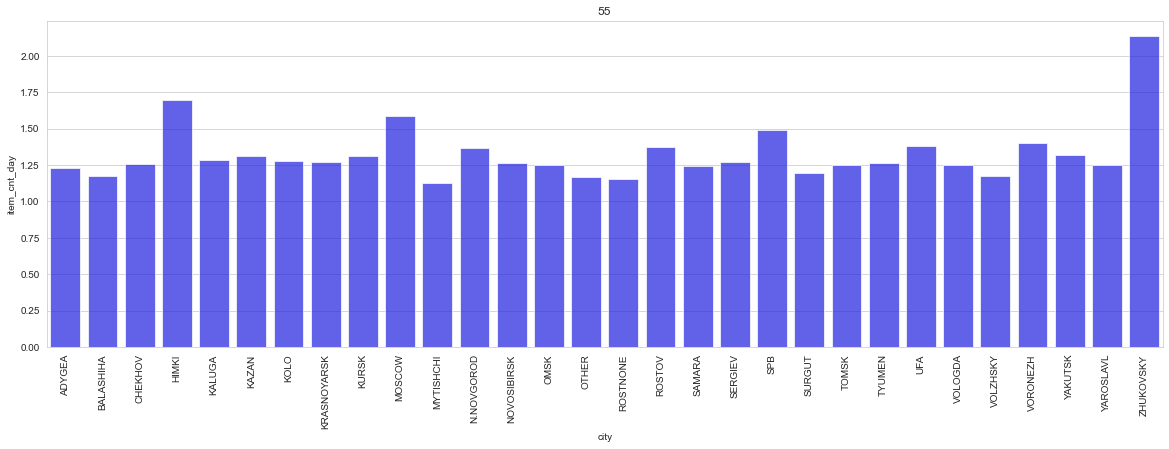

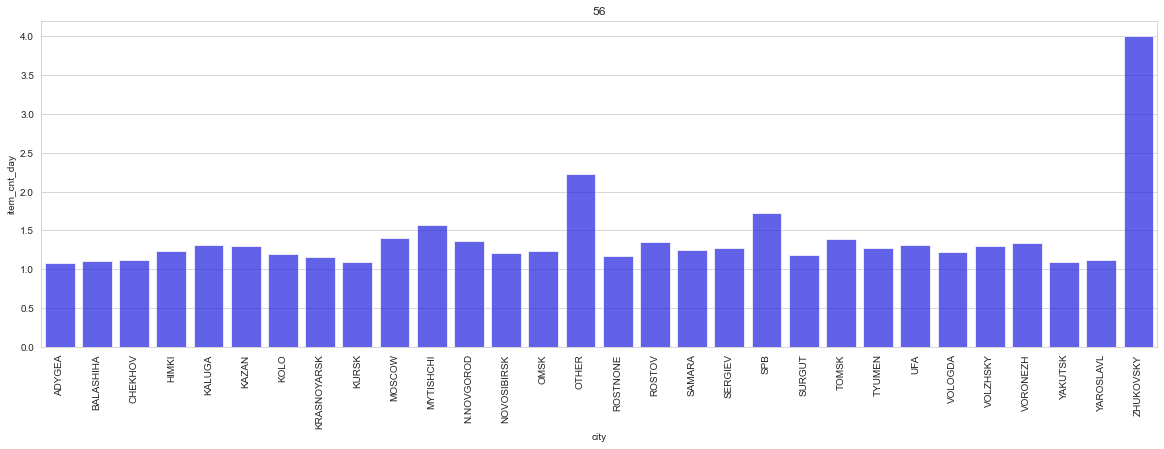

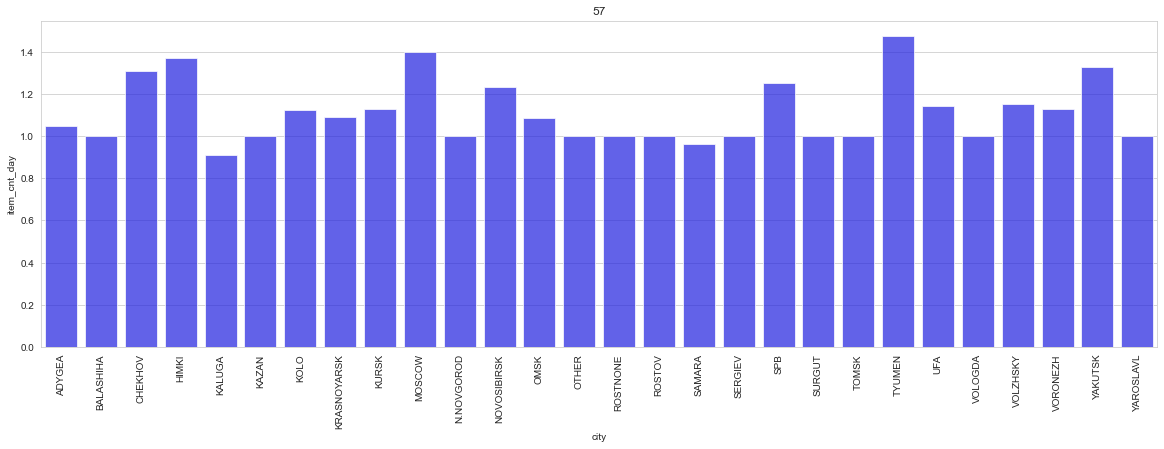

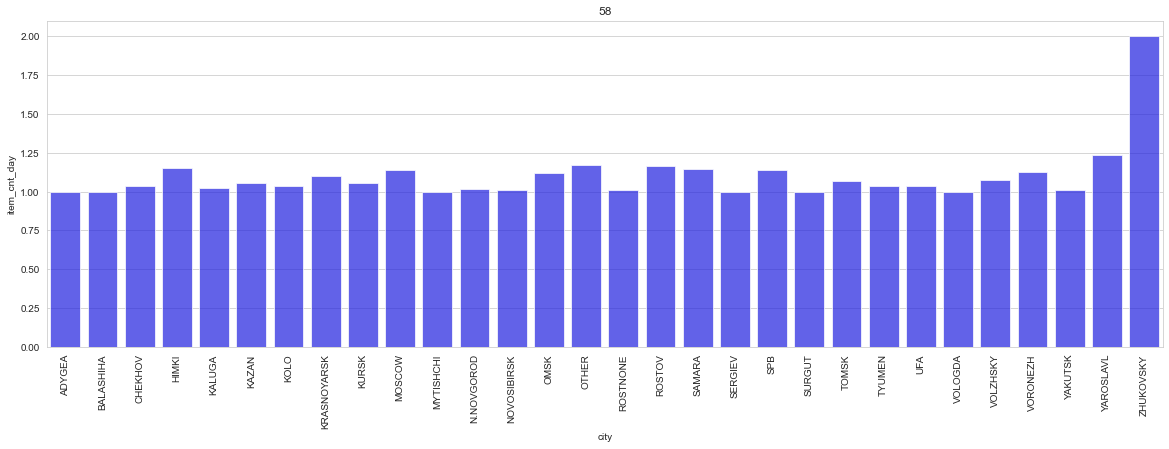

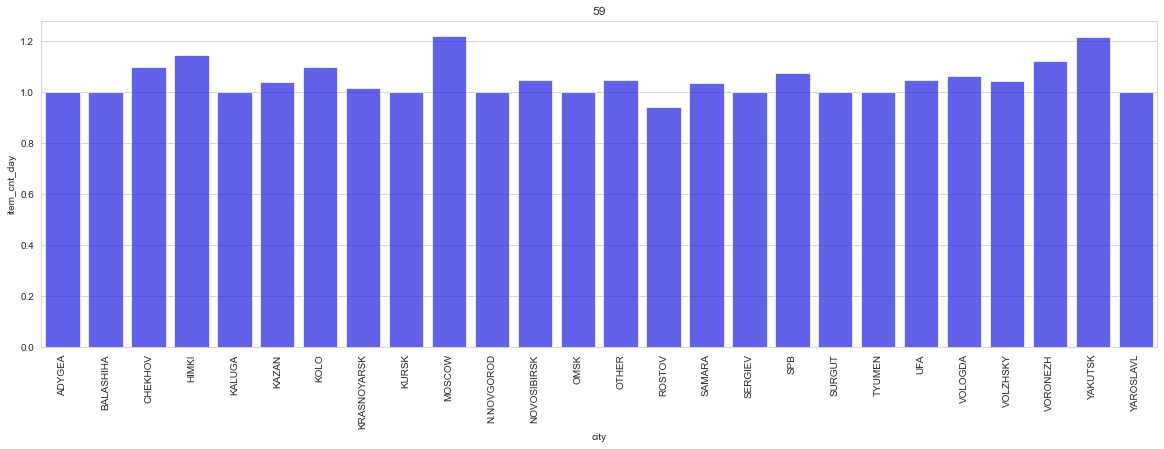

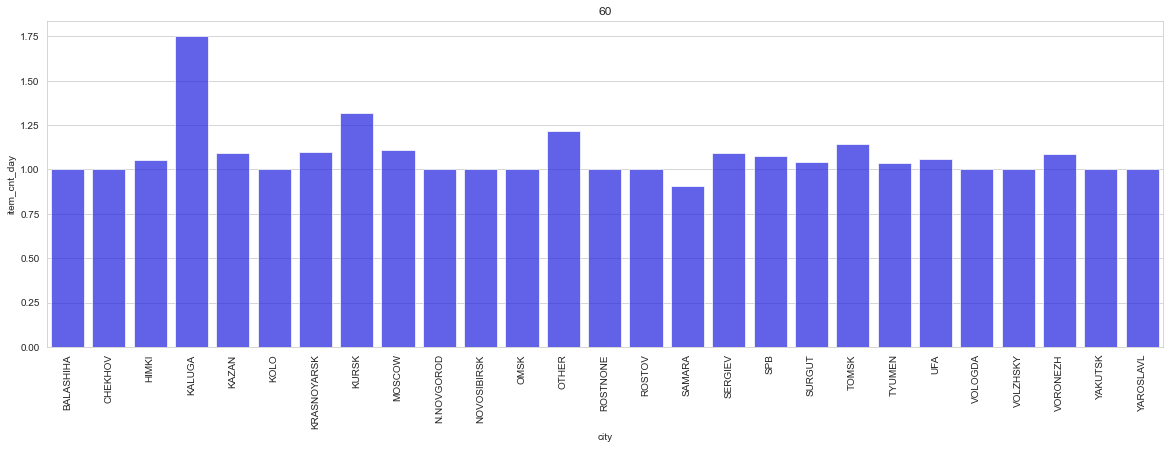

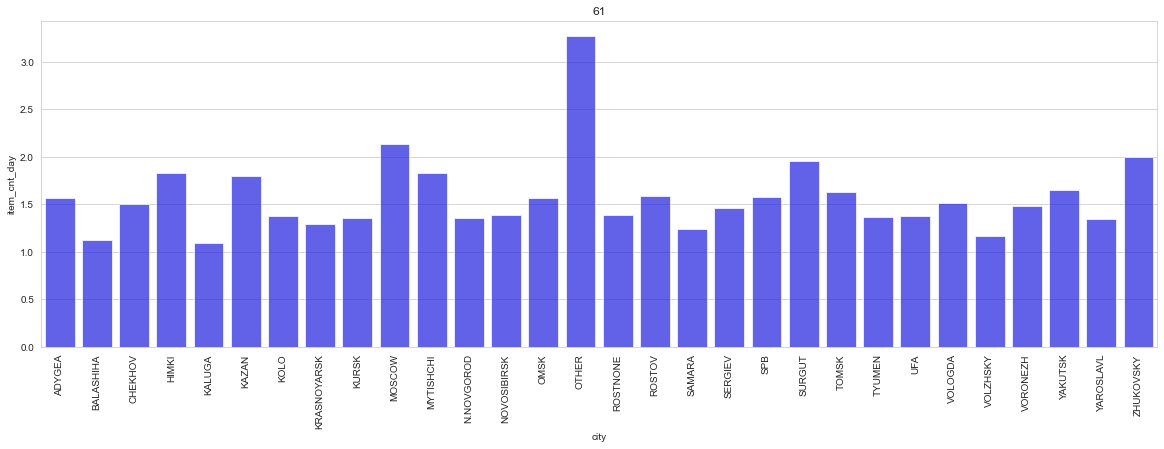

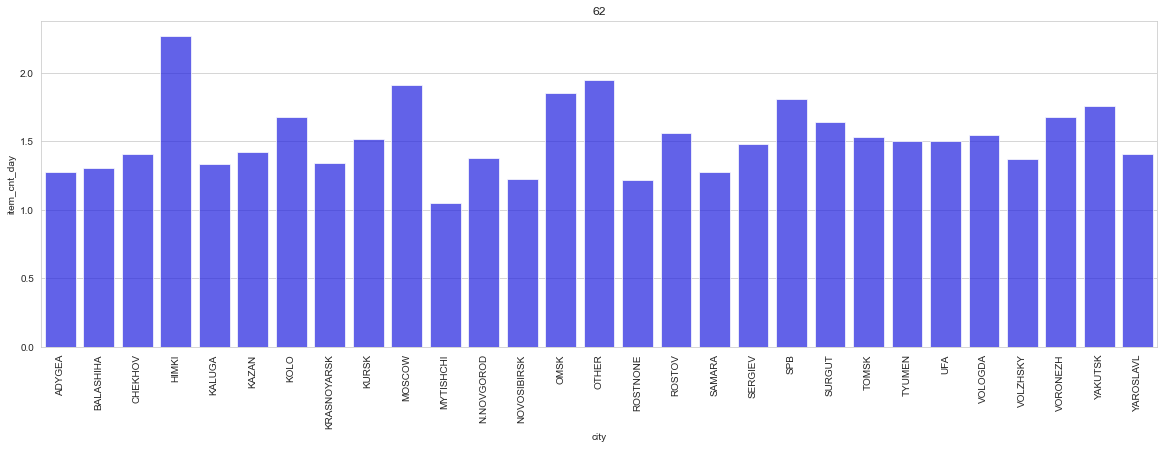

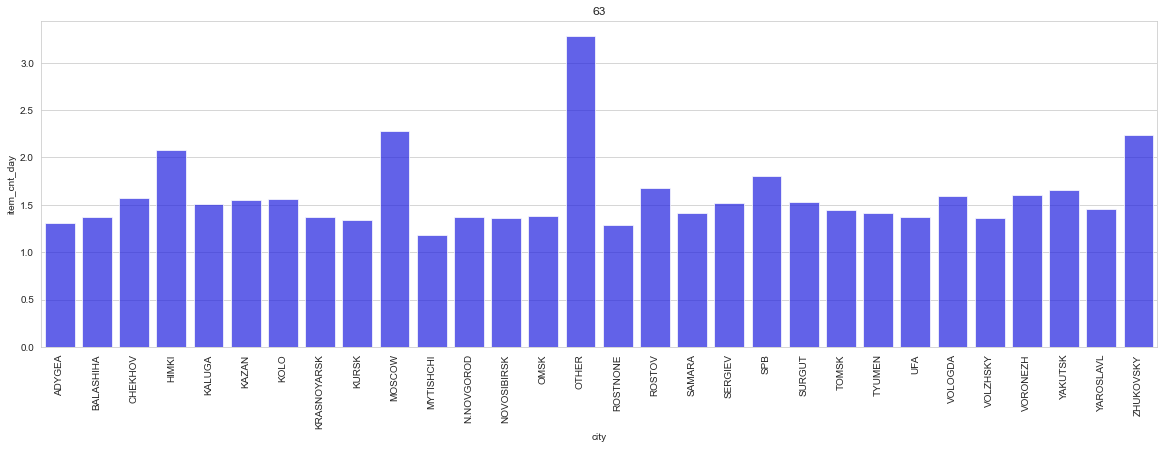

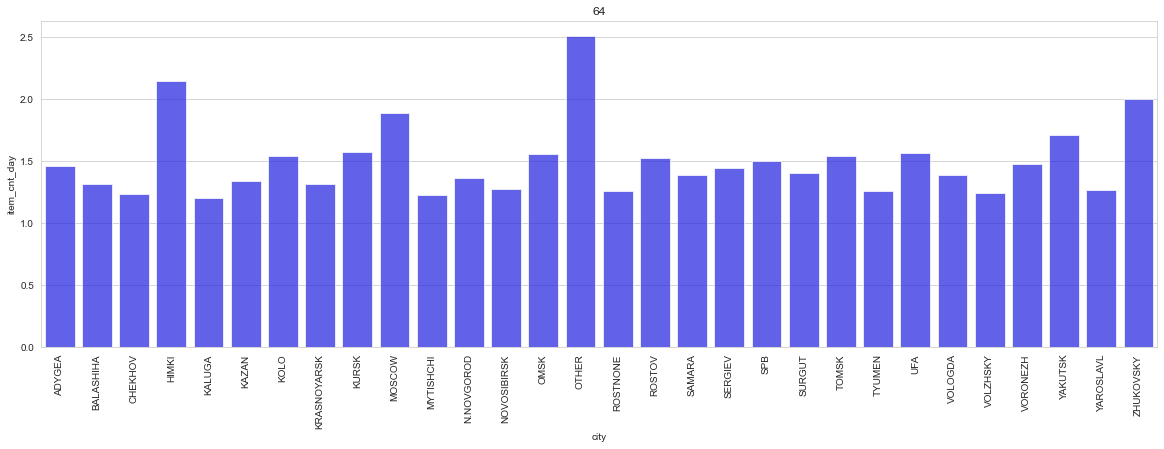

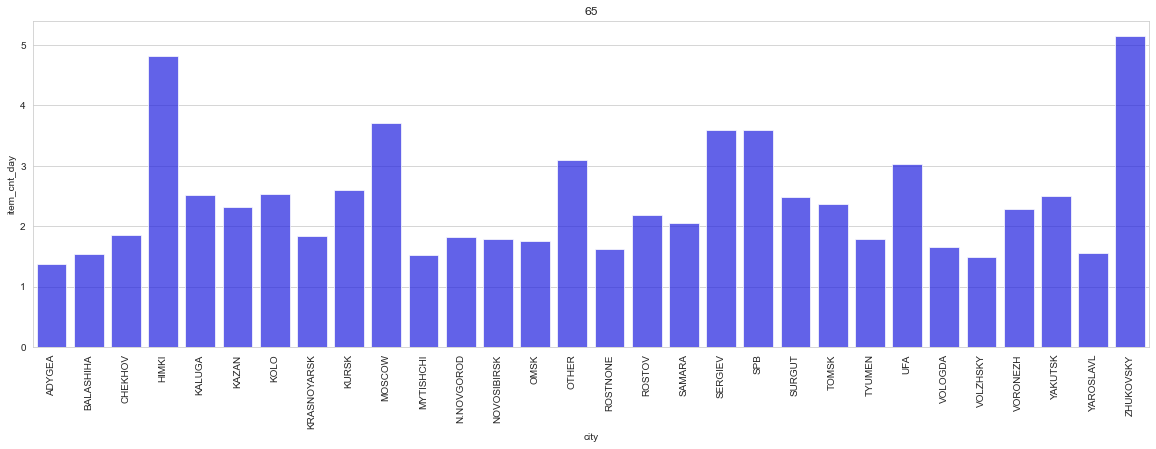

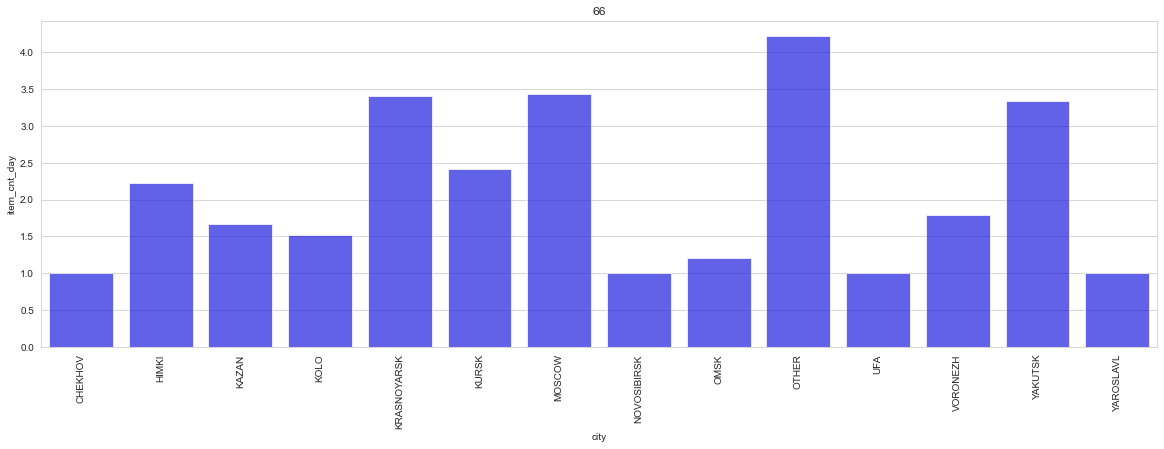

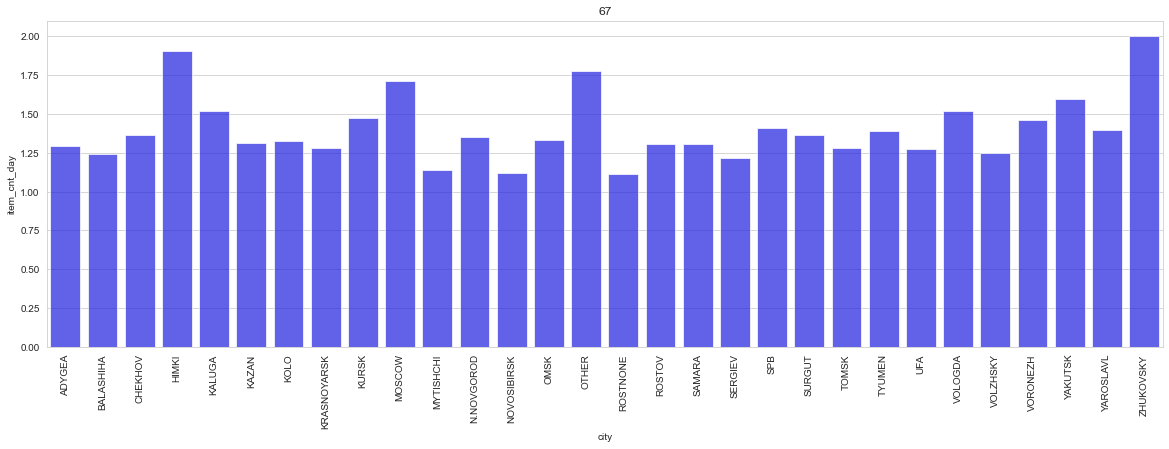

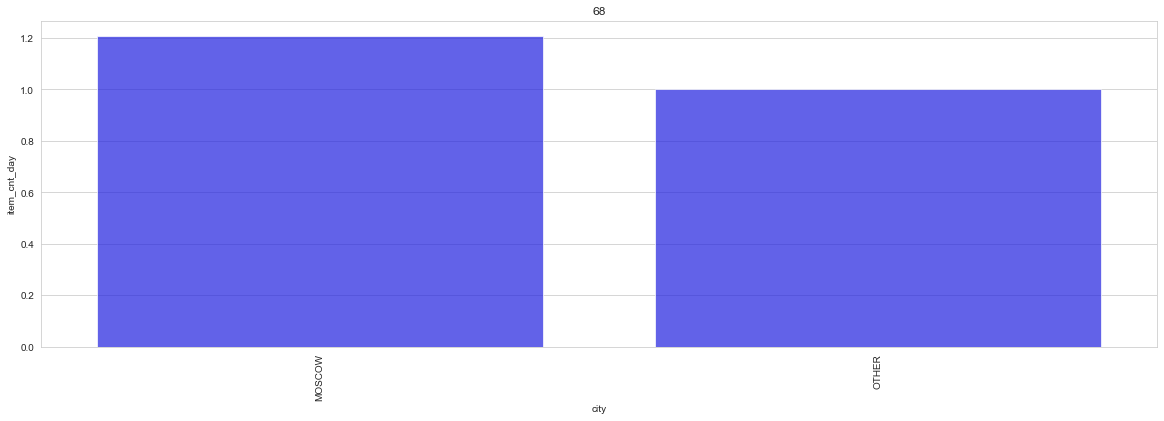

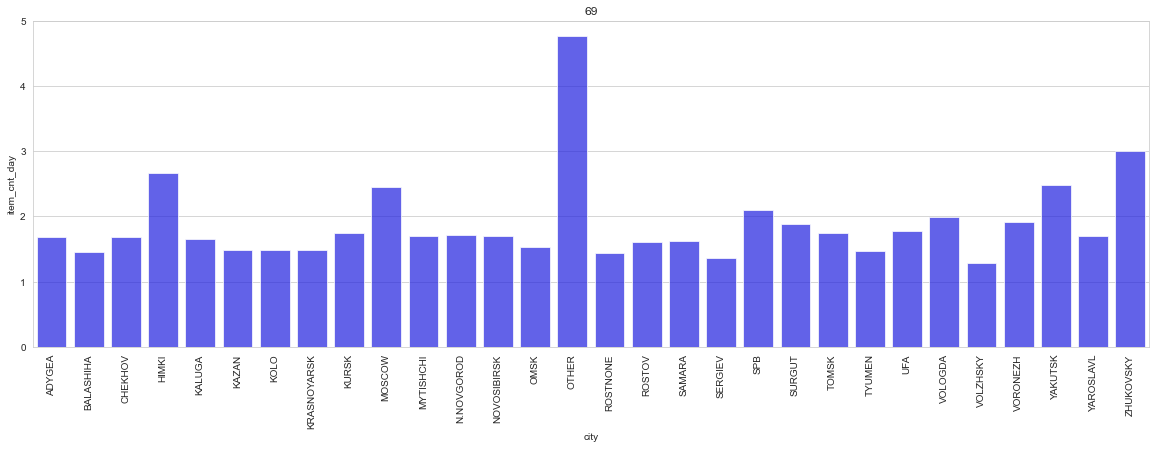

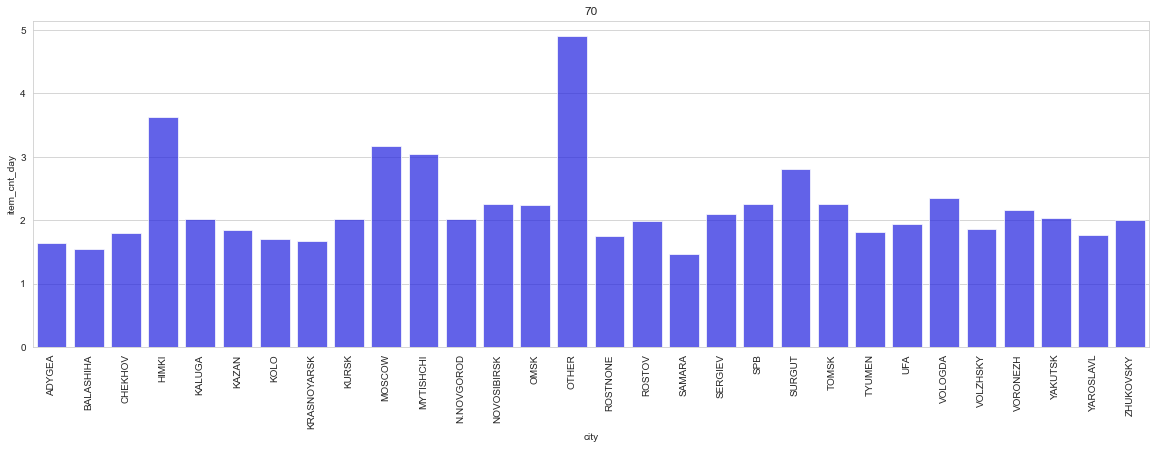

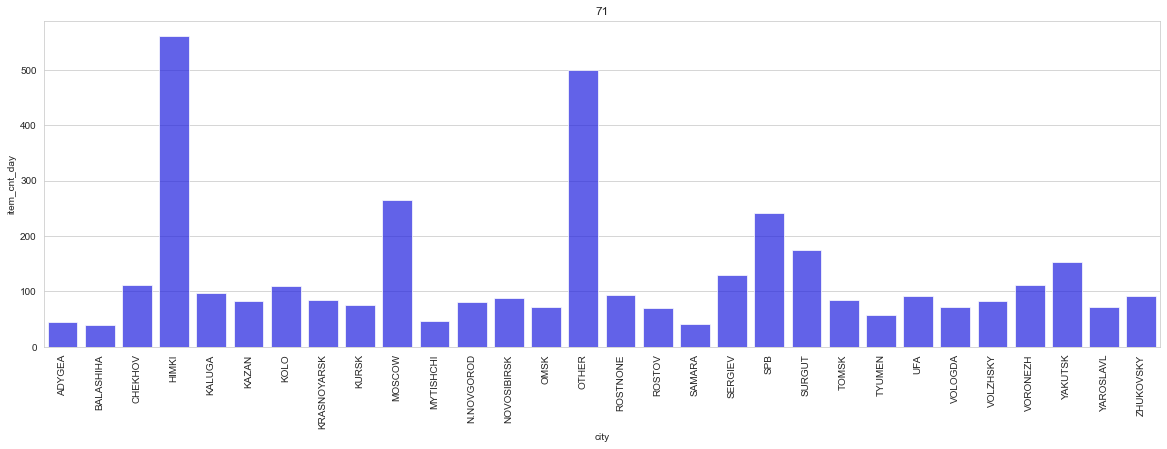

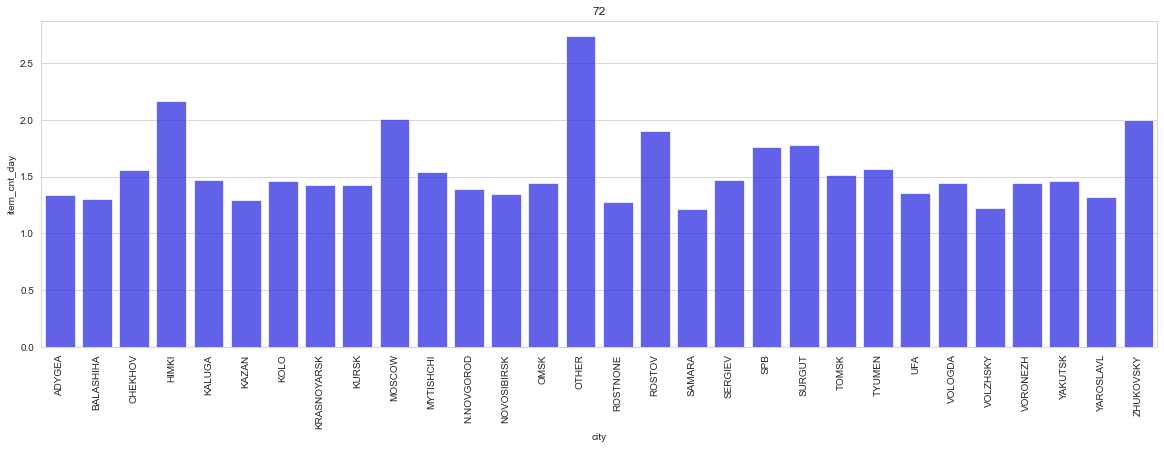

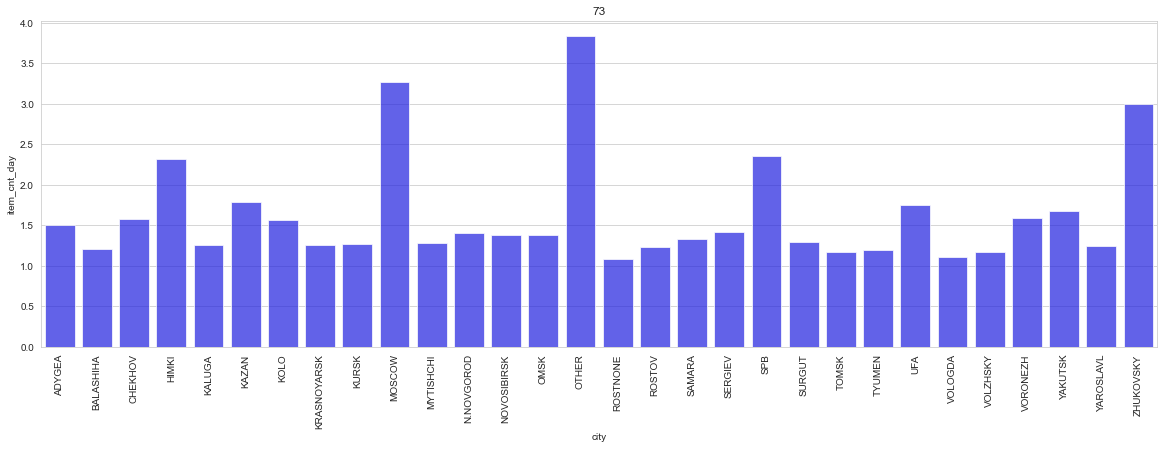

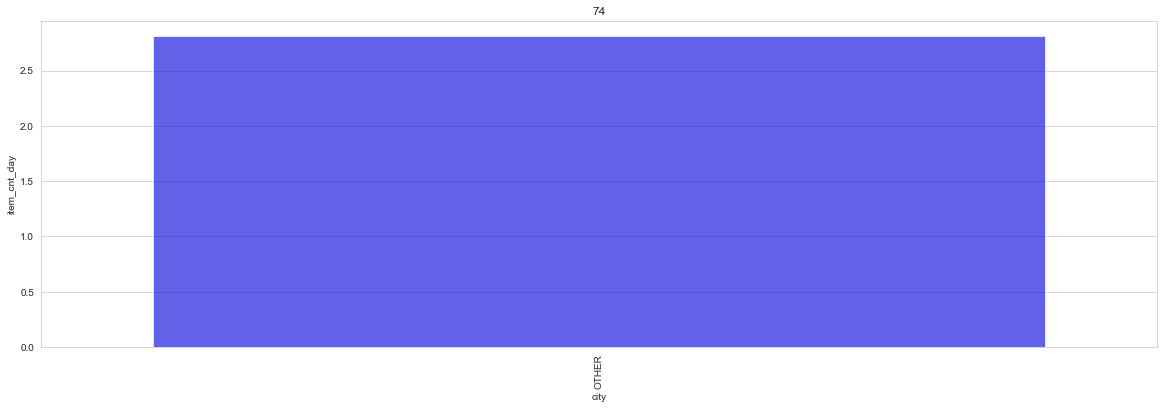

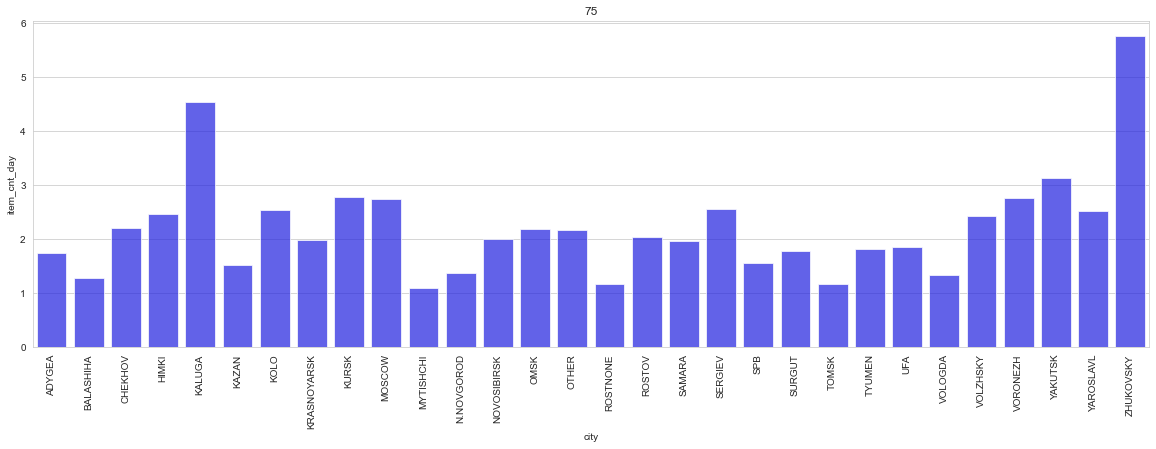

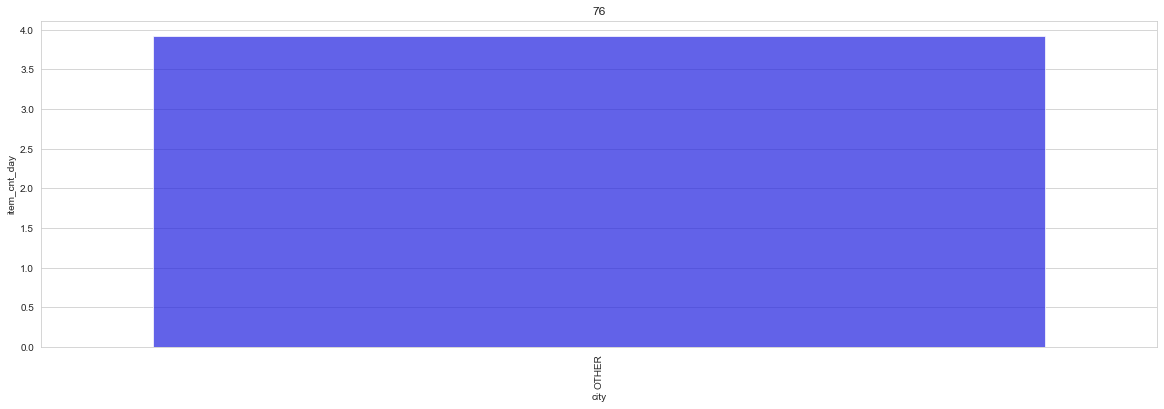

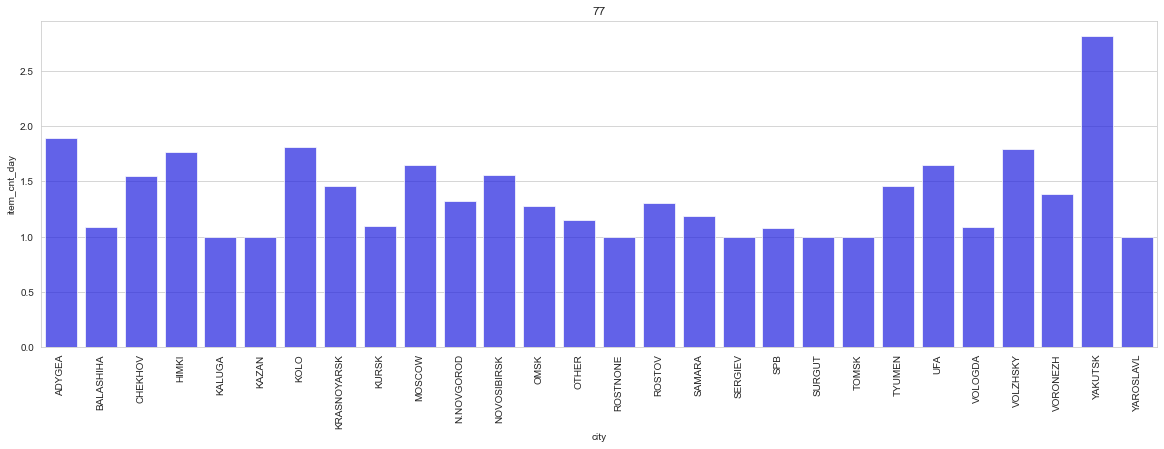

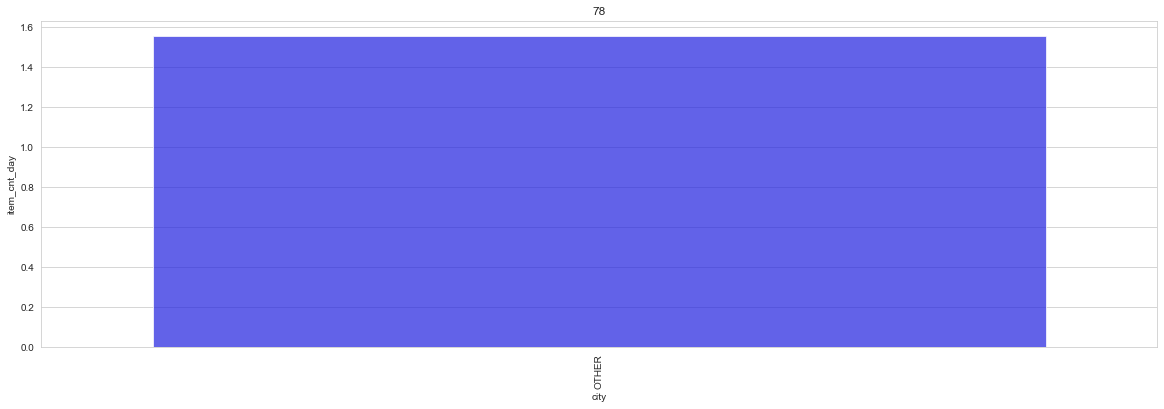

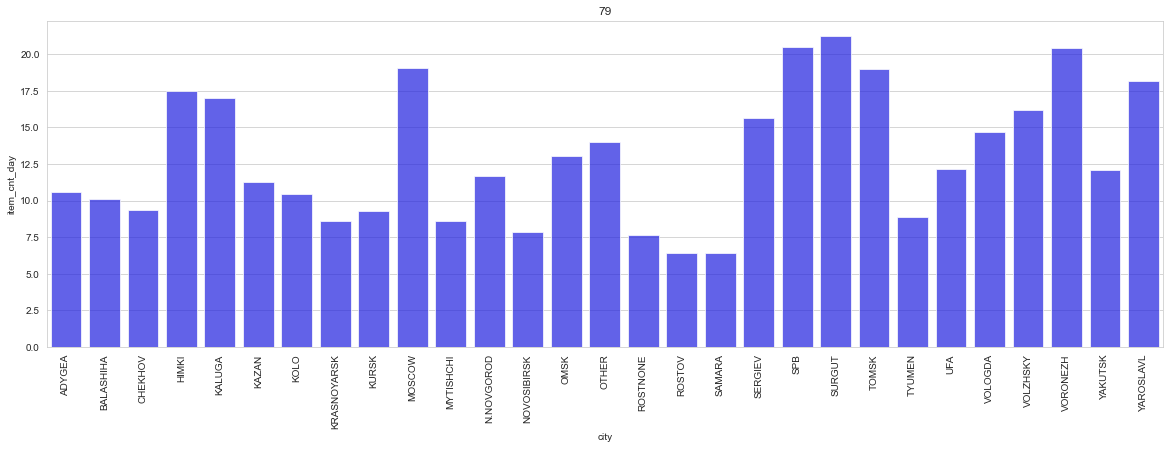

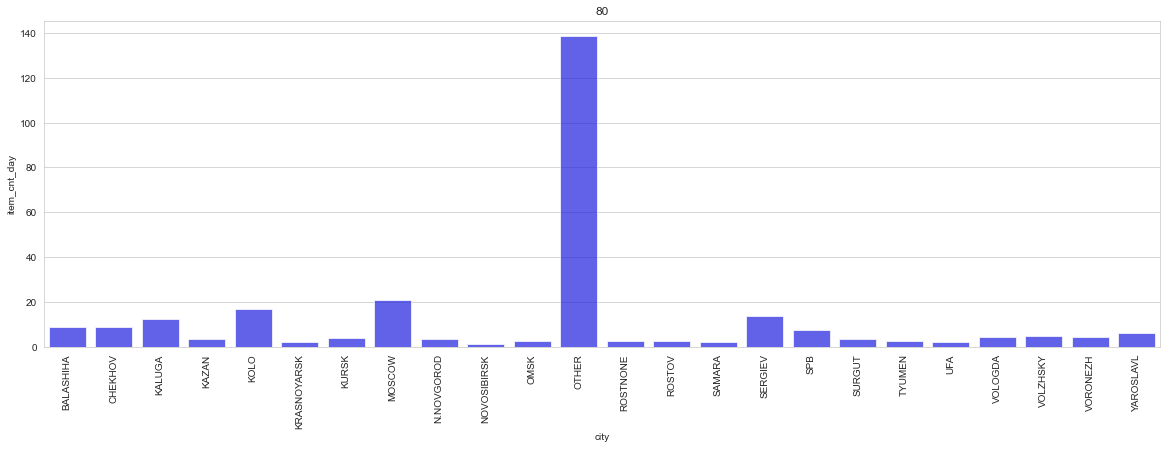

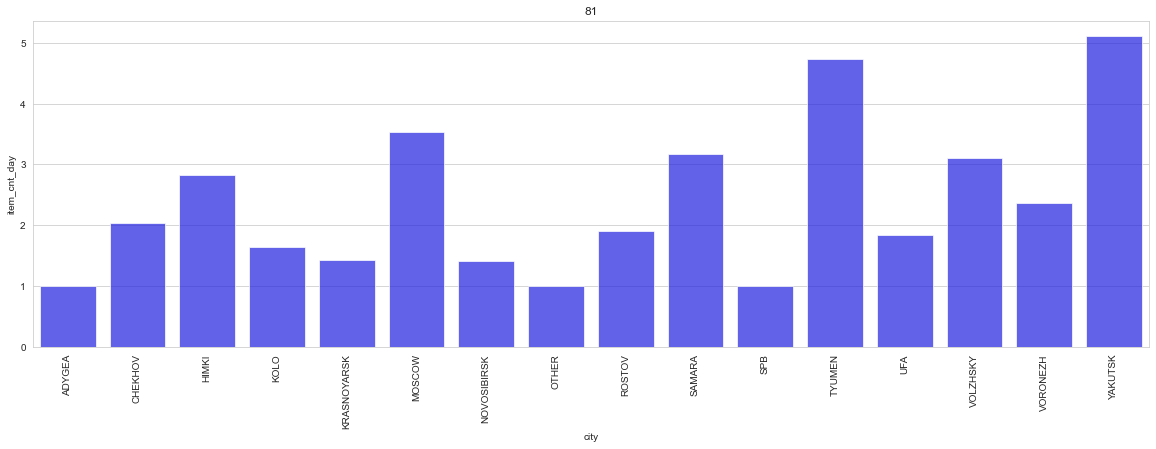

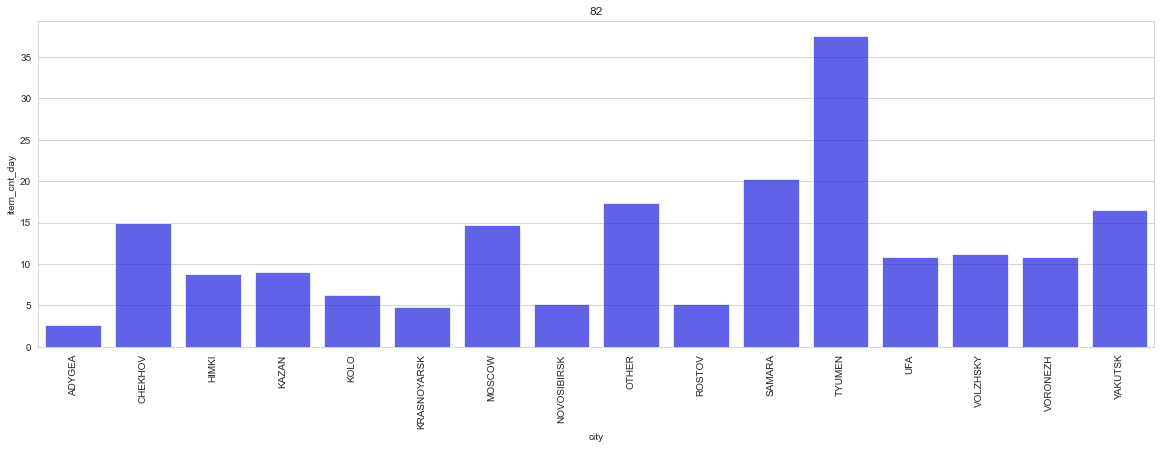

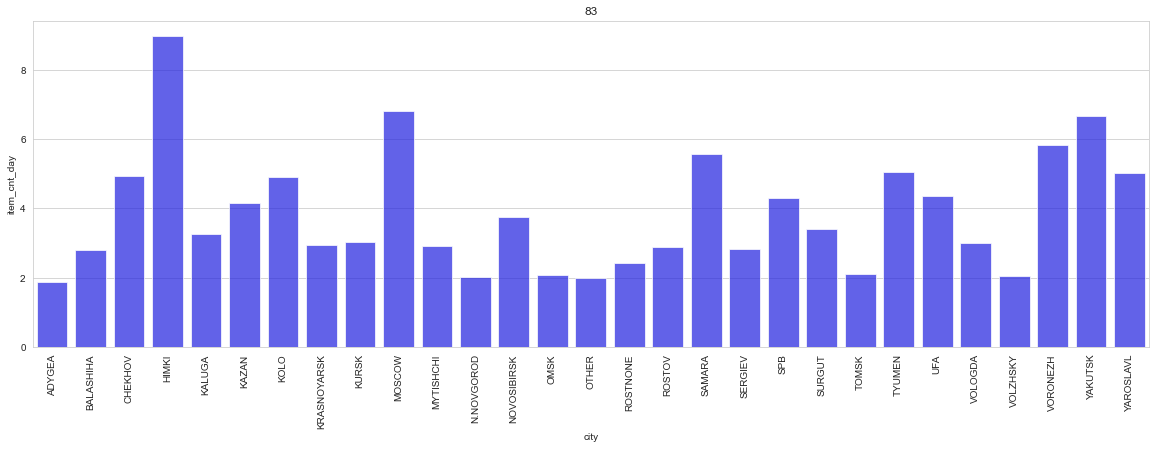

In [ ]:
for x in CategoriesByCities.item_category_id.unique():
    temporal = CategoriesByCities[CategoriesByCities["item_category_id"]==x]
    plt.figure(figsize=(20,6))
    sns.barplot(temporal["city"],temporal["item_cnt_day"], color="blue", alpha=0.7)
    plt.title(x)
    plt.xticks(rotation=90);

# Top performer shops

In [ ]:
most_sales = df.groupby(["date_block_num","shop_id"]).size().reset_index().sort_values(by=["date_block_num",0]).reset_index(drop=True)

In [ ]:
Top5mostSales = pd.DataFrame({"date_block_num":[],"shop_id":[],0:[]})

for x in most_sales.date_block_num.unique():
    temporal = most_sales[most_sales["date_block_num"]==x].iloc[-5:]
    Top5mostSales = Top5mostSales.append(temporal,ignore_index=True)

In [ ]:
Top5mostSalesCross = pd.crosstab(Top5mostSales.date_block_num, Top5mostSales.shop_id, Top5mostSales[0], aggfunc=sum)
Top5mostSalesCross.fillna(0,inplace=True)

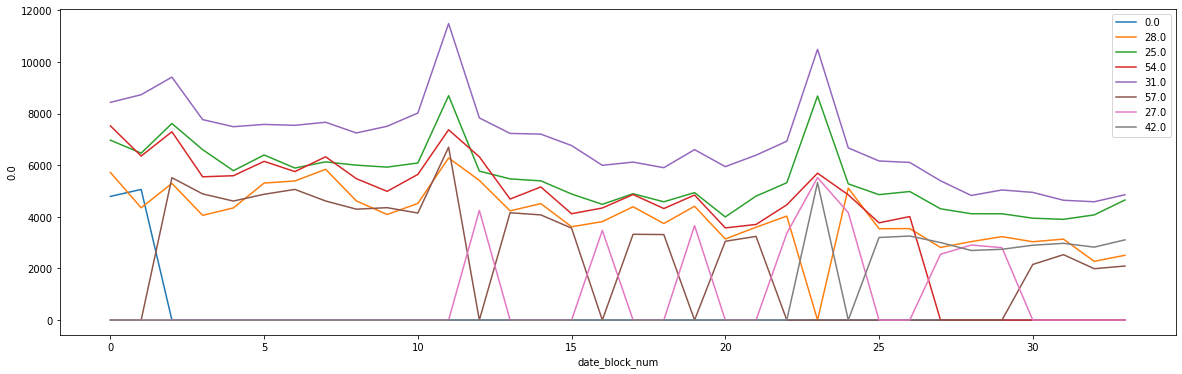

In [ ]:
plt.figure(figsize=(20,6))
for x in Top5mostSales.shop_id.unique():
    sns.lineplot(Top5mostSalesCross.index, Top5mostSalesCross[x], label=x)
    plt.legend()

In [ ]:
CountCategoriesSalesByShop = {}
for x in df.shop_id.unique():
    CountCategoriesSalesByShop[x] = [df[df.shop_id==x].item_category_id.nunique()]
CountCategoriesSalesByShop = pd.DataFrame(CountCategoriesSalesByShop).T.sort_values(by=0)

AttributeError: 'DataFrame' object has no attribute 'item_category_id'

In [ ]:
CountCategoriesSalesByShop.head()

### GET MEAN ENCODING SHOP BY CATEG

# FULLDF

In [ ]:
df_full = df[["date_block_num","shop_id","item_id"]].append(test.drop("ID",axis=1))
df_full.date_block_num.fillna(34,inplace=True)

In [ ]:
items_with_1_appearence = df.groupby("item_id").size().sort_values()[:2371].index
oneAppearence = pd.DataFrame({'date_block_num':[], 'shop_id':[], 'item_id':[]})
for i in items_with_1_appearence:
    oneAppearence = oneAppearence.append(df_full[df_full["item_id"]==i], ignore_index=True)

In [ ]:
#Items that ONLY appear ONCE and only in Trainset
oneAppearence.item_id.nunique()

2371

In [ ]:
#Items that appear only once in Train set, but many times in Test set --> 43 times each
oneAppearenceTrain_manyAppearenceTest = oneAppearence.groupby("item_id").size().sort_values(ascending=False)
mask = oneAppearenceTrain_manyAppearenceTest[oneAppearenceTrain_manyAppearenceTest>42].index

In [ ]:
#Son 83 items RAROS --> estos items no venden más de 1 o a lo sumo 2 unidades, podríamos poner una predicción de 1 de facto
df[df.item_id.isin(mask)].item_cnt_day.value_counts()

1.0    81
2.0     2
Name: item_cnt_day, dtype: int64

In [ ]:
#Ver items que no estén en el bloque 33 ni testset

In [ ]:
mask = df_full[df_full.date_block_num > 30].item_id.unique()

array([ 4261, 12752, 13556, ...,  7635,  7638,  7640], dtype=int64)

# Monthly

In [ ]:
monthly = df.groupby(["date_block_num","shop_id","item_id","item_category_id"]).sum()
monthly.reset_index(inplace=True)

In [ ]:
trial = monthly[monthly.ID > -1].groupby(["ID","item_category_id"]).size().reset_index()
trial.ID = trial.ID.astype("int")
trial.head()

ID  item_category_id  0
0   0                19  9
1   2                19  5
2   3                23  1
3   5                23  6
4   6                20  2

Text(0.5, 1.0, 'Total train sales by item category')

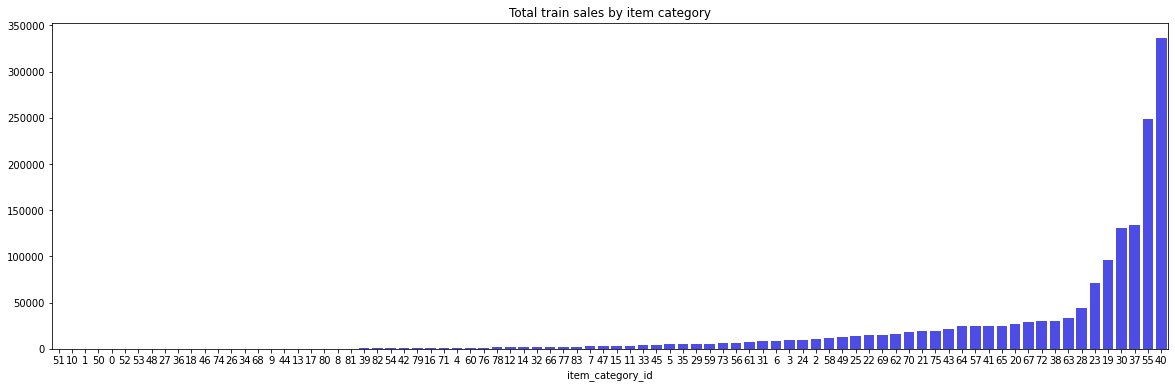

In [ ]:
plt.figure(figsize=(20,6))
sns.barplot(monthly.groupby(["item_category_id"]).size().sort_values().index.astype("str"), monthly.groupby(["item_category_id"]).size().sort_values().values,\
           color="blue", alpha=0.8)
plt.title("Total train sales by item category")

In [ ]:
monthly[monthly.item_category_id==categ].groupby("item_id").size().sort_values()

item_id
0          1
9992       1
10017      1
10019      1
10024      1
        ... 
10298    739
21427    767
32       785
21440    815
11921    890
Length: 4964, dtype: int64

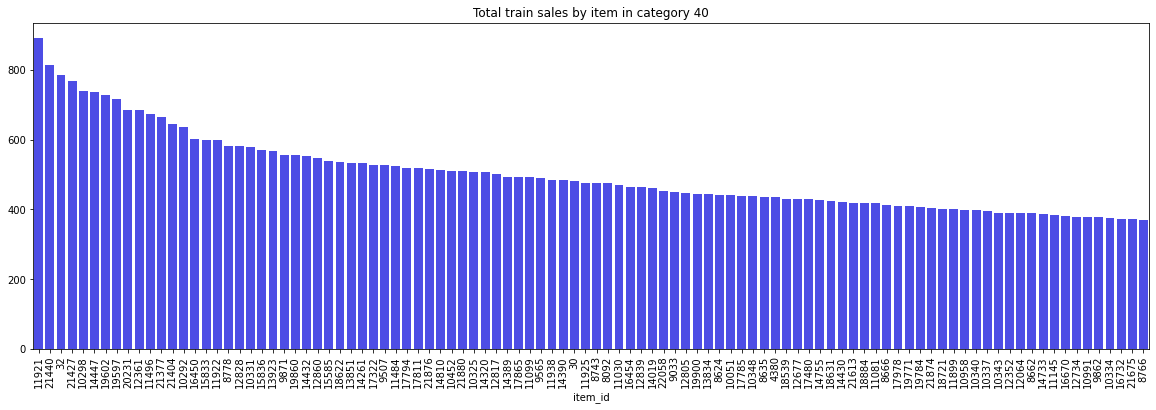

In [ ]:
plt.figure(figsize=(20,6))

categ = 40
sns.barplot(monthly[monthly.item_category_id==categ].groupby("item_id").size().sort_values(ascending=False)[:100].index.astype("str"),\
            monthly[monthly.item_category_id==categ].groupby("item_id").size().sort_values(ascending=False)[:100].values,\
           color="blue", alpha=0.8)
plt.title(f"Total train sales by item in category {categ}")
plt.xticks(rotation=90);

In [ ]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

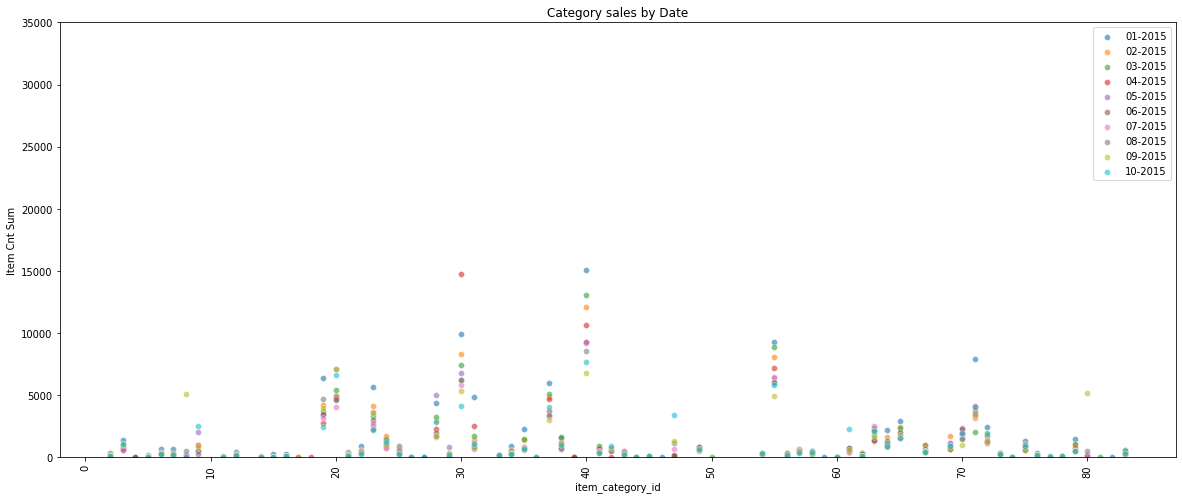

In [ ]:
plt.figure(figsize=(20,8))

for x in df.date.unique()[24:]:
    sns.scatterplot(df[df["date"]==x].groupby("item_category_id").sum()["item_cnt_day"].index,\
                 df[df["date"]==x].groupby("item_category_id").sum()["item_cnt_day"].values, label=x, alpha=0.6, palette="Blues")
    plt.title("Category sales by Date")
    plt.ylim([0,35000])
    plt.xticks(rotation=90)
    plt.ylabel("Item Cnt Sum")
    plt.legend();

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

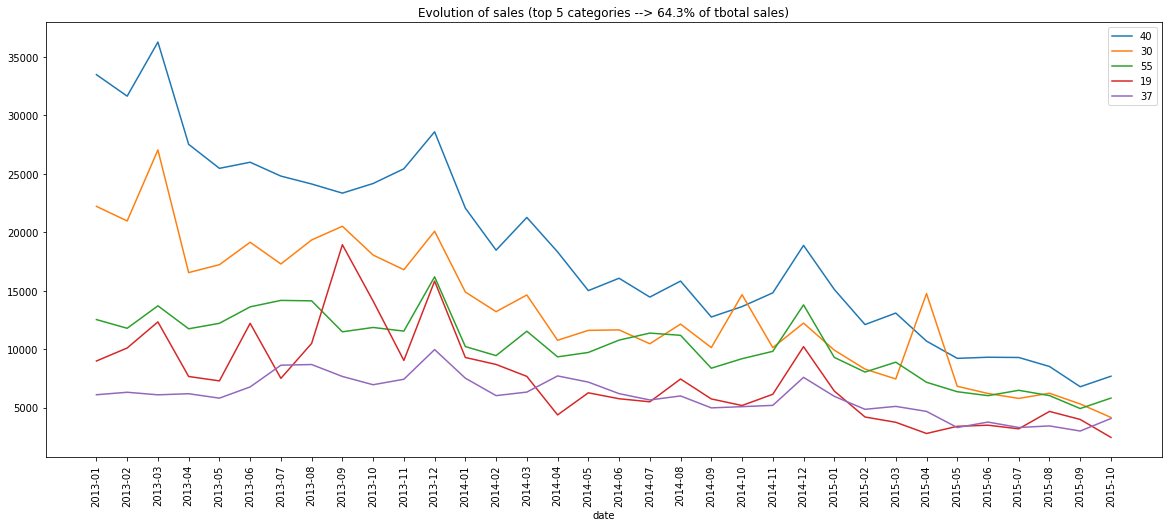

In [ ]:
#64.3% of sales
categories = [40,30,55,19,37]#,71,28,23,20,65]
plt.figure(figsize=(20,8))
for categ in categories:
    sns.lineplot(df[df["item_category_id"]==categ].groupby("date").sum()["item_cnt_day"].index,\
                 df[df["item_category_id"]==categ].groupby("date").sum()["item_cnt_day"].values, label=categ)
    plt.title("Evolution of sales (top 5 categories --> 64.3% of tbotal sales)")
    plt.xticks(rotation=90)
    plt.legend()

In [ ]:
#Agregamos item_cnt del mes anterior
monthly.rolling(3).mean()["item_cnt_day-1"] = monthly.item_cnt_day.shift(1)

In [ ]:
#Cuanto vendio la store X en el mes anterior del item Y?

In [ ]:
lastMonth_shop_item = monthly.groupby(["date","shop_id","item_id"]).sum().reset_index()[["date","shop_id","item_id","item_cnt_day"]]

In [ ]:
lastMonth_shop_item["date_shop_item"] = lastMonth_shop_item["date"].astype("str") + "_" +\
                                        lastMonth_shop_item["shop_id"].astype("str") + "_" + lastMonth_shop_item["item_id"].astype("str")

In [ ]:
lastMonth_shop_item

date  shop_id  item_id  item_cnt_day       date_shop_item
0       2013-01-01        0       32           6.0      2013-01-01_0_32
1       2013-01-01        0       33           3.0      2013-01-01_0_33
2       2013-01-01        0       35           1.0      2013-01-01_0_35
3       2013-01-01        0       43           1.0      2013-01-01_0_43
4       2013-01-01        0       51           2.0      2013-01-01_0_51
...            ...      ...      ...           ...                  ...
1609119 2015-10-01       59    22087           6.0  2015-10-01_59_22087
1609120 2015-10-01       59    22088           2.0  2015-10-01_59_22088
1609121 2015-10-01       59    22091           1.0  2015-10-01_59_22091
1609122 2015-10-01       59    22100           1.0  2015-10-01_59_22100
1609123 2015-10-01       59    22102           1.0  2015-10-01_59_22102

[1609124 rows x 5 columns]

In [ ]:
df

date  date_block_num  shop_id  item_id  item_price  \
0       2013-01-01               0       59    22154      999.00   
1       2013-01-01               0       25     2552      899.00   
2       2013-01-01               0       25     2552      899.00   
3       2013-01-01               0       25     2554     1709.05   
4       2013-01-01               0       25     2555     1099.00   
...            ...             ...      ...      ...         ...   
2935844 2015-10-01              33       25     7409      299.00   
2935845 2015-10-01              33       25     7460      299.00   
2935846 2015-10-01              33       25     7459      349.00   
2935847 2015-10-01              33       25     7440      299.00   
2935848 2015-10-01              33       25     7460      299.00   

         item_cnt_day  item_category_id shop_id + item_id        ID  
0                 1.0                37          59_22154  150983.0  
1                 1.0                58           25_2552   -9999.0  
2                -1.0                58           25_2552   -9999.0  
3                 1.0                58           25_2554   -9999.0  
4                 1.0                56           25_2555   -9999.0  
...               ...               ...               ...       ...  
2935844           1.0                55           25_7409   58431.0  
2935845           1.0                55           25_7460   59331.0  
2935846           1.0                55           25_7459   58430.0  
2935847           1.0                57           25_7440   60342.0  
2935848           1.0                55           25_7460   59331.0  

[2935849 rows x 9 columns]

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

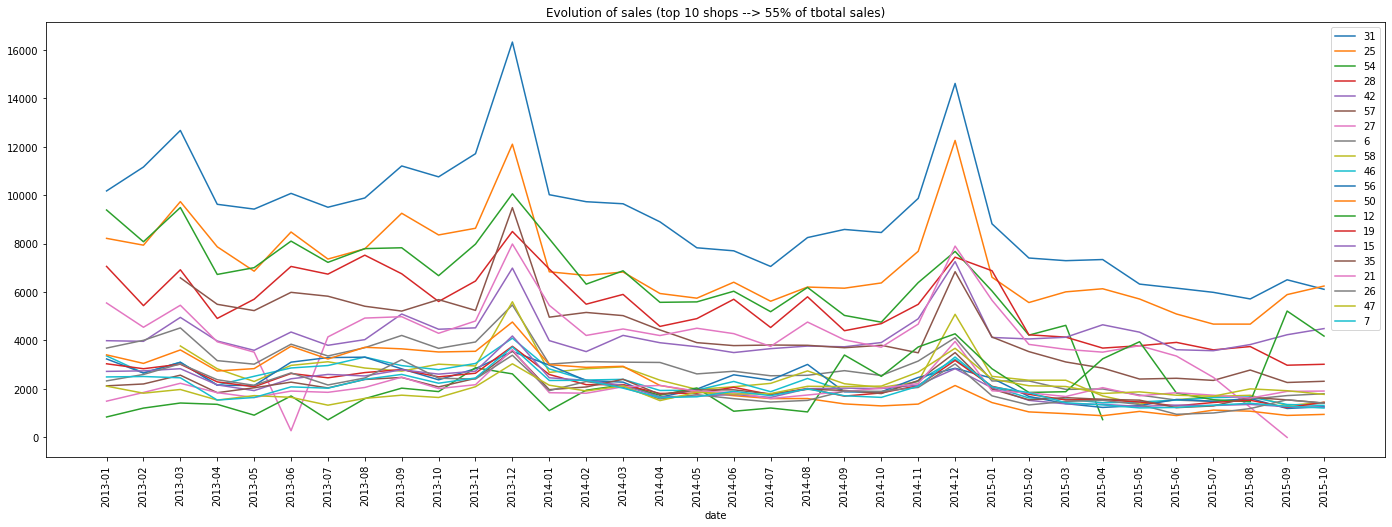

In [ ]:
#64.3% of sales
categories = [31, 25, 54, 28, 42, 57, 27,  6, 58, 46, 56, 50, 12, 19, 15, 35, 21,
            26, 47,  7]
plt.figure(figsize=(24,8))
for categ in categories:
    sns.lineplot(df[df["shop_id"]==categ].groupby("date").sum()["item_cnt_day"].index,\
                 df[df["shop_id"]==categ].groupby("date").sum()["item_cnt_day"].values, label=categ)
    plt.title("Evolution of sales (top 10 shops --> ~80% of tbotal sales)")
    plt.xticks(rotation=90)
    plt.legend()

# Inter-monthly change

In [ ]:
a = df.groupby(["date","item_category_id"]).sum()[["item_cnt_day"]].reset_index()

In [ ]:
sales_category_month_ = pd.crosstab(a.date, a.item_category_id, values= a.item_cnt_day, aggfunc="sum").fillna(0)
sales_category_month = pd.crosstab(a.date, a.item_category_id, values= a.item_cnt_day, aggfunc="sum").fillna(0)
sales_category_month = sales_category_month.reset_index()
sales_category_month_ = sales_category_month_.reset_index()

In [ ]:
for column in sales_category_month_.columns[1:]:
    try:
        sales_category_month.loc[:,column] = (sales_category_month_.loc[:,column] / sales_category_month_.loc[:,column].shift(1))-1
        sales_category_month.loc[:,str(column)+"_diff"] = (sales_category_month_.loc[:,column] - sales_category_month_.loc[:,column].shift(1))
    except:
        sales_category_month.loc[x,column] = 0
sales_category_month.fillna(0,inplace=True)

In [ ]:
(monthly.groupby("item_id").sum()["item_cnt_day"].sort_values(ascending=False) / monthly.item_cnt_day.sum())*100

item_id
20949    5.143405
2808     0.472698
3732     0.456169
17717    0.433912
5822     0.397867
           ...   
7547     0.000000
13474   -0.000027
18062   -0.000027
11871   -0.000027
1590    -0.000302
Name: item_cnt_day, Length: 21807, dtype: float64

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


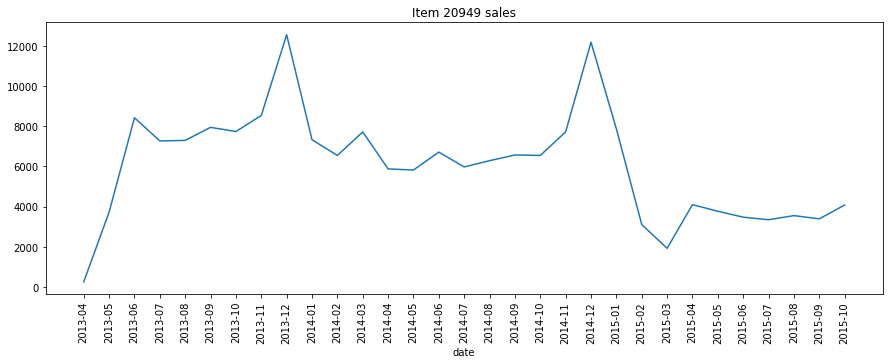

In [ ]:
plt.figure(figsize=(15,5))
idt = 20949
sns.lineplot(monthly[monthly["item_id"]==idt].groupby(["date"]).sum().index,\
             monthly[monthly["item_id"]==idt].groupby(["date"]).sum().item_cnt_day.values)
plt.title(f"Item {idt} sales")
plt.xticks(rotation=90);

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


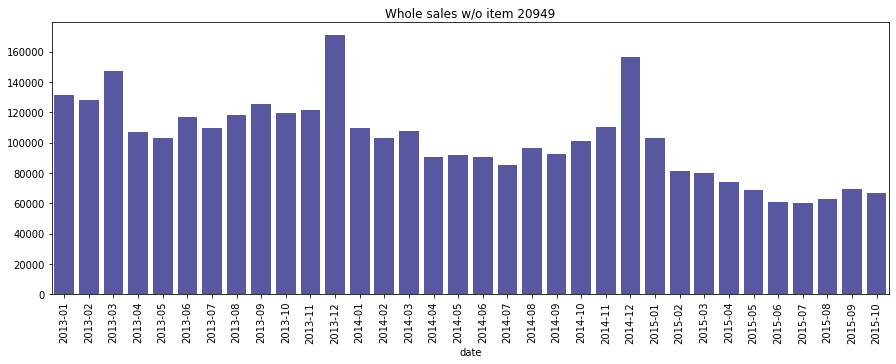

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(monthly[monthly["item_id"]!=idt].groupby(["date"]).sum().index,\
             monthly[monthly["item_id"]!=idt].groupby(["date"]).sum().item_cnt_day.values, color="darkblue", alpha=0.7)
plt.title(f"Whole sales w/o item {idt}")
plt.xticks(rotation=90);

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


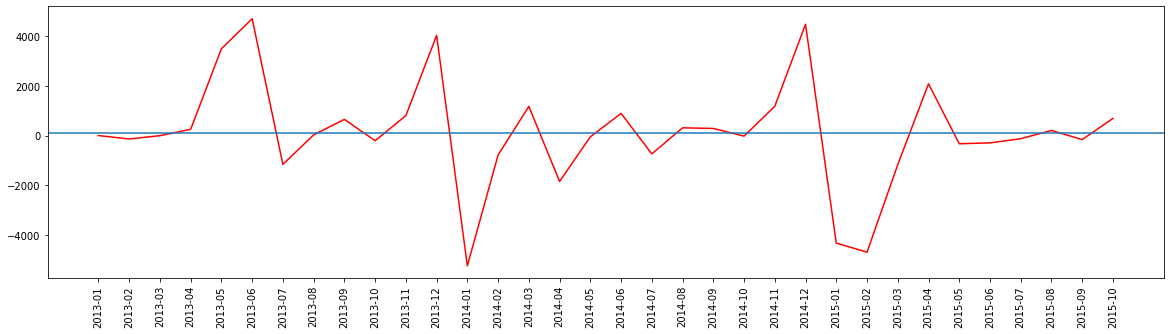

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(sales_category_month["date"].values,sales_category_month["71_diff"].values, color="red")
ax.axhline(sales_category_month["71_diff"].mean())
plt.xticks(rotation=90);

In [ ]:
b = df.groupby(["date","shop_id"]).sum()[["item_cnt_day"]].reset_index()

In [ ]:
sales_shop_month_ = pd.crosstab(b.date, b.shop_id, values= b.item_cnt_day, aggfunc="sum").fillna(0)
sales_shop_month = pd.crosstab(b.date, b.shop_id, values= b.item_cnt_day, aggfunc="sum").fillna(0)
sales_shop_month = sales_shop_month.reset_index()
sales_shop_month_ = sales_shop_month_.reset_index()

In [ ]:
for column in sales_shop_month_.columns[1:]:
    try:
        sales_shop_month.loc[:,column] = (sales_shop_month_.loc[:,column] / sales_shop_month_.loc[:,column].shift(1))-1
        sales_shop_month.loc[:,str(column)+"_diff"] = (sales_shop_month_.loc[:,column] - sales_shop_month_.loc[:,column].shift(1))
    except:
        sales_shop_month.loc[x,column] = 0
sales_shop_month.fillna(0,inplace=True)

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


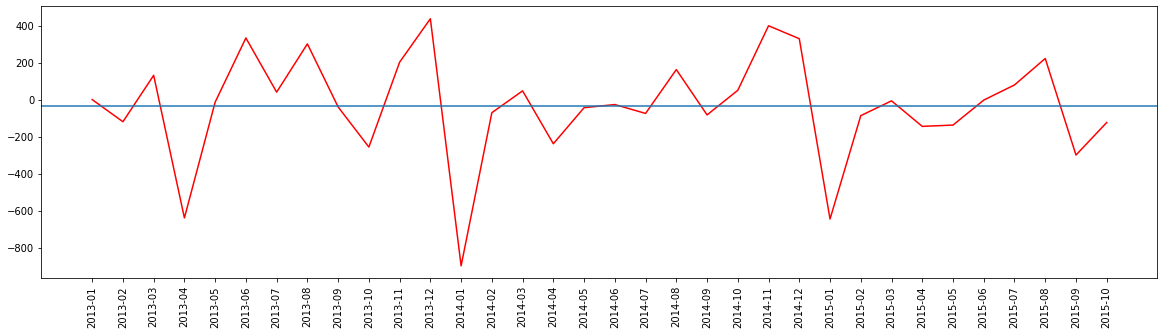

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(sales_shop_month["date"].values,sales_shop_month["59_diff"].values, color="red")
ax.axhline(sales_shop_month["59_diff"].mean())
plt.xticks(rotation=90);

In [ ]:
sales_shop_month_.head(10)

shop_id     date       0       1       2       3       4       5       6  \
0        2013-01  5578.0  2947.0  1146.0   767.0  2114.0     0.0  3686.0   
1        2013-02  6127.0  3364.0   488.0   798.0  2025.0   877.0  4007.0   
2        2013-03     0.0     0.0   753.0   959.0  2060.0  1355.0  4519.0   
3        2013-04     0.0     0.0   583.0   647.0   285.0  1008.0  3168.0   
4        2013-05     0.0     0.0   553.0   710.0  1211.0  1110.0  3022.0   
5        2013-06     0.0     0.0   832.0   784.0  1464.0  1393.0  3847.0   
6        2013-07     0.0     0.0   807.0   721.0  1378.0  1265.0  3360.0   
7        2013-08     0.0     0.0   875.0   890.0  1713.0  1510.0  3702.0   
8        2013-09     0.0     0.0   945.0  1026.0  1536.0  1298.0  4208.0   
9        2013-10     0.0     0.0   795.0   793.0  1482.0  1267.0  3675.0   

shop_id       7       8  ...      50      51      52      53      54     55  \
0        2495.0  1463.0  ...  3406.0  2748.0  1812.0  2055.0  9386.0    0.0   
1        2513.0  1156.0  ...  3054.0  2284.0  1737.0  1906.0  8075.0    0.0   
2        2460.0   977.0  ...  3610.0  2605.0  2034.0  2365.0  9488.0    0.0   
3        1540.0    -1.0  ...  2740.0  1945.0  1446.0  1515.0  6726.0    0.0   
4        1647.0     0.0  ...  2839.0  2243.0  1482.0  1767.0  7006.0  852.0   
5        2085.0     0.0  ...  3761.0  2200.0  1815.0  2125.0  8101.0  728.0   
6        2031.0     0.0  ...  3235.0  2273.0  1616.0  1975.0  7225.0  795.0   
7        2397.0     0.0  ...  3718.0  2142.0  1772.0  2367.0  7792.0  719.0   
8        2599.0     0.0  ...  3655.0  1903.0  2125.0  2440.0  7827.0  812.0   
9        2236.0     0.0  ...  3525.0  1809.0  1965.0  2245.0  6676.0  916.0   

shop_id      56      57      58      59  
0        3238.0     0.0     0.0  2017.0  
1        2655.0     0.0     0.0  1897.0  
2        3099.0  6586.0  3773.0  2028.0  
3        2153.0  5493.0  2831.0  1388.0  
4        2140.0  5233.0  2308.0  1374.0  
5        3105.0  5987.0  2972.0  1707.0  
6        3294.0  5827.0  3122.0  1747.0  
7        3311.0  5413.0  2863.0  2048.0  
8        2829.0  5213.0  2735.0  2008.0  
9        2375.0  5686.0  3022.0  1751.0  

[10 rows x 61 columns]

# Done

In [ ]:
items_cat[items_cat["item_category_id"]==59]

item_category_name  item_category_id
59  Музыка - Музыкальное видео                59

In [ ]:
#Cuantas categorias vende cada shop?
pd.crosstab(monthly.shop_id, monthly.item_category_id)a

item_category_id  0   1    2    3   4    5    6    7   8    9   ...  74    75  \
shop_id                                                         ...             
0                  1   1   37    2  11   26   19    0   0    0  ...   0    78   
1                  0   0   27    2  10   17   20    0   0    0  ...   0    48   
2                  0   0  236  206  25   40  184   57   2    0  ...   0   294   
3                  0   0  147  186  21   84  151   52   8    0  ...   0   123   
4                  0   0  216  168  48  127  185   36   1    0  ...   0   323   
5                  0   0  174  162  29   84  135   48   8    0  ...   0    93   
6                  0   0  272  219  16  132  189   53   6    0  ...   0   586   
7                  0   0  251  203  50  137  208   41   4    0  ...   0   344   
8                  0   0   15    0   2    7    8    0   0    0  ...   0    25   
9                  0   0   15   17   0    0    8    7   0    0  ...   0     1   
10                 0   0  108  135   6   43   94   30   0    0  ...   0   413   
11                 0   0    2    4   0    1    4    1   0    0  ...   0     8   
12                 0   0  168  208   9   83  107  100  13  202  ...   0   363   
13                 0   0    0    6   0    0    0    0   0    0  ...   0    30   
14                 0   0  177  192  13   43  138   44   5    0  ...   0   223   
15                 0   0  214  202  32   50  193   62   9    0  ...   0   527   
16                 0   0  253  200  60  134  211   43  10    0  ...   0   489   
17                 0   0  135  106  16   60   89   21   1    0  ...   0   112   
18                 0   0  347  234  33  160  219   52   0    0  ...   0   274   
19                 0   0  262  211  40  116  187   34   8    0  ...   0   308   
20                 0   0    0    0   0    0    0    0   0    0  ...   0     0   
21                 0   0  185  232  15  130  162   83  11    0  ...   0   348   
22                 0   0  105  170   9   87   81   47  11    0  ...   0  1103   
23                 0   0   46    4   3   18   22    0   0    0  ...   0   176   
24                 0   0  239  218  27  122  206   41   9    0  ...   0  1273   
25                 1   0  404  330  30  224  290  123  11    0  ...   0   813   
26                 0   0  229  202  19  121  163   76  11    0  ...   0   488   
27                 0   0  352  250  48  199  301   96  11    0  ...   0   621   
28                 0   0  382  297  37  206  321  114  11    0  ...   0   417   
29                 0   0  271  175  34  121  155   32   9    0  ...   0   653   
30                 0   0  230  140  43  127  174   21   9    0  ...   0   357   
31                 0   0  436  307  60  230  300  108  12    0  ...   0  1134   
32                 0   0   27    5   8   19   21    0   0    0  ...   0    98   
33                 0   0   34   42   1   12   27   13   3    0  ...   0    23   
34                 0   0    0   61   0    0    7   34   3    0  ...   0    17   
35                 0   0  235  225  16  111  185   77   7    0  ...   0   161   
36                 0   0    0    5   0    0    2    0   0    0  ...   0     3   
37                 0   0  174  185  17   67  131   55   1    0  ...   0   332   
38                 1   0  283  224  25   58  231   79   2    0  ...   0   252   
39                 0   0   43  103   2   19   51   51   6    0  ...   0    36   
40                 0   0    0    1   0    0    0    0   0    0  ...   0     0   
41                 0   0  190  149  25   62  175   31   4    0  ...   0   317   
42                 0   0  322  281  33  214  234  124   6    0  ...   0   401   
43                 0   0  247  135  26   89  165   26   7    0  ...   0   236   
44                 0   0  112  127   4   50   75   30   3    0  ...   0   309   
45                 0   1  152  148  19   79  127   41   5    0  ...   0   233   
46                 0   0  269  246  28  103  246   54  10    0  ...   0   375   
47                 0   0  298  

# Cnt of selling shops

In [ ]:
for x in monthly.item_category_id.unique():
    monthly.loc[monthly[monthly["item_category_id"]==x].index, "cnt_of_shops"] = monthly[monthly["item_category_id"]==x].shop_id.nunique()

In [ ]:
mask = monthly[monthly["item_category_id"]==40].shop_id.unique()
monthly[monthly["shop_id"].isin(mask)]

date  shop_id  item_id  item_category_id  item_price  \
0        2013-01        0       32                40       884.0   
1        2013-01        0       33                37      1041.0   
2        2013-01        0       35                40       247.0   
3        2013-01        0       43                40       221.0   
4        2013-01        0       51                57       257.0   
...          ...      ...      ...               ...         ...   
1609119  2015-10       59    22087                83       357.0   
1609120  2015-10       59    22088                83       238.0   
1609121  2015-10       59    22091                83       179.0   
1609122  2015-10       59    22100                42       629.0   
1609123  2015-10       59    22102                42      1250.0   

         item_cnt_day  cnt_of_shops  
0                 6.0          58.0  
1                 3.0          58.0  
2                 1.0          58.0  
3                 1.0          58.0  
4                 2.0          50.0  
...               ...           ...  
1609119           6.0          51.0  
1609120           2.0          51.0  
1609121           1.0          51.0  
1609122           1.0          46.0  
1609123           1.0          46.0  

[1595563 rows x 7 columns]

In [ ]:
monthly.groupby("item_category_id").sum()["item_cnt_day"].sort_values(ascending=False)[:10]

item_category_id
40    634171.0
30    456540.0
55    348591.0
19    254887.0
37    203284.0
71    187998.0
28    174954.0
23    169944.0
20    127319.0
65     73077.0
Name: item_cnt_day, dtype: float64

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Mean price by category')

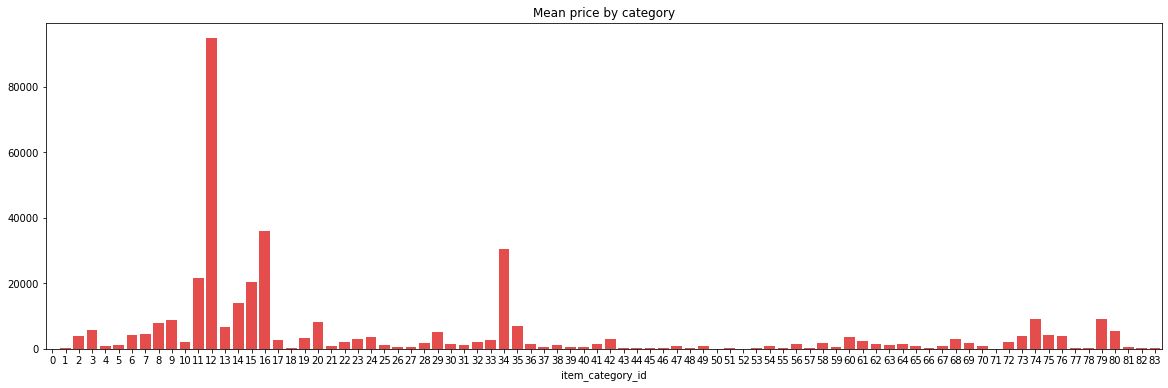

In [ ]:
plt.figure(figsize=(20,6))
sns.barplot(monthly.groupby("item_category_id").mean()["item_price"].sort_values().index,\
            monthly.groupby("item_category_id").mean()["item_price"].sort_values().values,\
           color="red", alpha=.8)
plt.title("Mean price by category")

In [ ]:
test[test["item_id"]==13477]

Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []

In [ ]:
df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_category_id'],
      dtype='object')

In [ ]:
for x in df.columns:
    print(f"{x}: {df[x].nunique()}")

date: 1034
date_block_num: 34
shop_id: 60
item_id: 21807
item_price: 19993
item_cnt_day: 198
item_category_id: 84


In [ ]:
"""
> Hay un item negativo
> Hay un claro outlier
> 
"""
df.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [ ]:
df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

   item_category_id  
0                37  
1                58  
2                58  
3                58  
4                56

In [ ]:
((df.item_cnt_day.value_counts() / df.shape[0]) * 100).sort_values(ascending=False)[:100]

 1.0      89.560873
 2.0       6.614816
 3.0       1.612821
 4.0       0.670505
 5.0       0.356762
            ...    
-3.0       0.000477
 60.0      0.000477
 53.0      0.000477
 54.0      0.000443
 100.0     0.000443
Name: item_cnt_day, Length: 62, dtype: float64

In [ ]:
df["returns"] = np.where(df.item_cnt_day<0,1,0)

In [ ]:
b = df.groupby("date_block_num").sum()[["returns","item_cnt_day"]]
b["ratio"] = b.item_cnt_day / b.returns

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='date_block_num'>

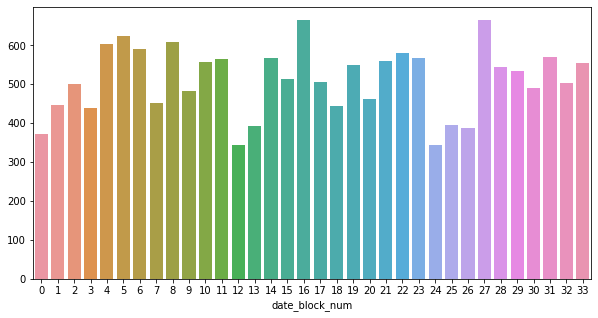

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(b.index, b.ratio.values)

In [ ]:
trial = df.groupby("date_block_num").agg({"item_cnt_day":["count","sum"]})
trial["ratio"] = trial.iloc[:,1] / trial.iloc[:,0]

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

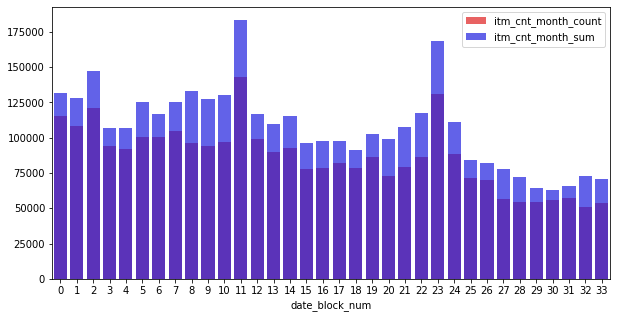

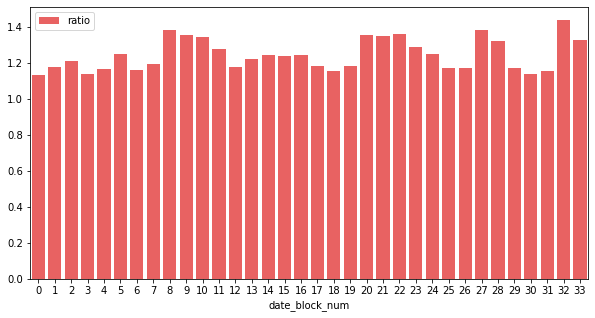

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(trial.iloc[:,0].index, trial.iloc[:,0].values, color="red", alpha=0.7, label="itm_cnt_month_count")
sns.barplot(trial.iloc[:,1].index, trial.iloc[:,1].values, color="blue", alpha=0.7, label="itm_cnt_month_sum")
plt.legend()
plt.figure(figsize=(10,5))
sns.barplot(trial.iloc[:,2].index, trial.iloc[:,2].values, color="red", alpha=0.7, label="ratio")
plt.legend()

In [ ]:
monthly = df.groupby(["date_block_num","shop_id","item_id"]).sum()
monthly.reset_index(inplace=True)

In [ ]:
monthly[monthly.returns == 1]

date_block_num  shop_id  item_id  item_price  item_cnt_day  \
4015                  0        2     2920     3593.00           6.0   
4086                  0        2     4163    11130.00           9.0   
4129                  0        2     5272     4195.00           3.0   
4147                  0        2     5643     4775.21           0.0   
4220                  0        2     7867     1497.50           1.0   
...                 ...      ...      ...         ...           ...   
1607066              33       57     8448    14770.00           1.0   
1607913              33       58     3115      698.00           0.0   
1608397              33       58    15680     1197.00           1.0   
1608801              33       59     6503     5997.00           1.0   
1609113              33       59    21404      507.00           1.0   

         item_category_id  returns  
4015                  126        1  
4086                  525        1  
4129                  150        1  
4147                    4        1  
4220                   63        1  
...                   ...      ...  
1607066                18        1  
1607913               110        1  
1608397               120        1  
1608801                90        1  
1609113               120        1  

[7176 rows x 7 columns]

In [ ]:
#monthly.item_price = np.log(monthly.item_price)
sns.pairplot(monthly)

In [ ]:
test

ID  shop_id  item_id
0            0        5     5037
1            1        5     5320
2            2        5     5233
3            3        5     5232
4            4        5     5268
...        ...      ...      ...
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969

[214200 rows x 3 columns]

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='date_block_num'>

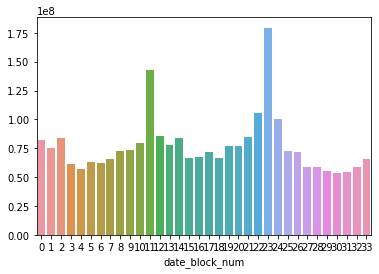

In [ ]:
sns.barplot(monthly.index, monthly.item_price.values)

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='item_price'>

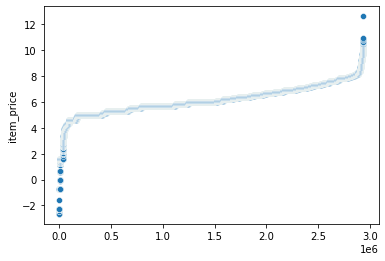

In [ ]:
sns.scatterplot(range(df.shape[0]), np.log(df.item_price.sort_values().reset_index(drop=True)))

In [ ]:
np.percentile(df.item_price, 98)

3590.0

In [ ]:
df[df.item_price>3590]

date  date_block_num  shop_id  item_id  item_price  \
207      11.01.2013               0       25     2220      3990.0   
209      02.01.2013               0       25     2412      5490.0   
305      14.01.2013               0       25     3438      3699.0   
666      05.01.2013               0       25     1153      4790.0   
667      08.01.2013               0       25     1166      3870.0   
...             ...             ...      ...      ...         ...   
2935765  28.10.2015              33       25     7224      4499.0   
2935766  07.10.2015              33       25     7223      3999.0   
2935781  29.10.2015              33       25     7224      4499.0   
2935782  30.10.2015              33       25     7134      3599.0   
2935813  01.10.2015              33       25     7640      4040.0   

         item_cnt_day  
207               1.0  
209               1.0  
305               1.0  
666               1.0  
667               1.0  
...               ...  
2935765           4.0  
2935766          35.0  
2935781           1.0  
2935782           1.0  
2935813           1.0  

[58341 rows x 6 columns]

In [ ]:
df.item_price.mean(), df.item_price.max()

(890.8532326979881, 307980.0)

In [ ]:
df[df.item_price>307979]

date  date_block_num  shop_id  item_id  item_price  \
1163158  13.12.2013              11       12     6066    307980.0   

         item_cnt_day  
1163158           1.0

In [ ]:
mean_price_category = df.groupby("item_category_id").agg({"item_price":["mean","count"]})
#mean_price_category.columns = []

In [ ]:
mean_price_category

In [ ]:
df.item_category_id.value_counts().sort_values().index

Int64Index([51, 10,  1, 50, 52, 53,  0, 48, 27, 18, 46, 36, 74, 26, 68, 44, 17,
            13, 39, 81, 80, 60,  8, 34,  9, 16,  4, 78, 42, 14, 77, 76, 82,  7,
            66, 32, 54, 45, 15, 47, 11, 59, 83,  5, 12, 33, 56, 79, 61, 29, 73,
            58, 24,  2,  6, 25, 31, 35, 49, 22,  3, 62, 43, 69, 71, 21, 57, 41,
            70, 64, 67, 75, 38, 72, 65, 63, 20, 28, 23, 37, 19, 55, 30, 40],
           dtype='int64')

C:\Users\NDominut\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

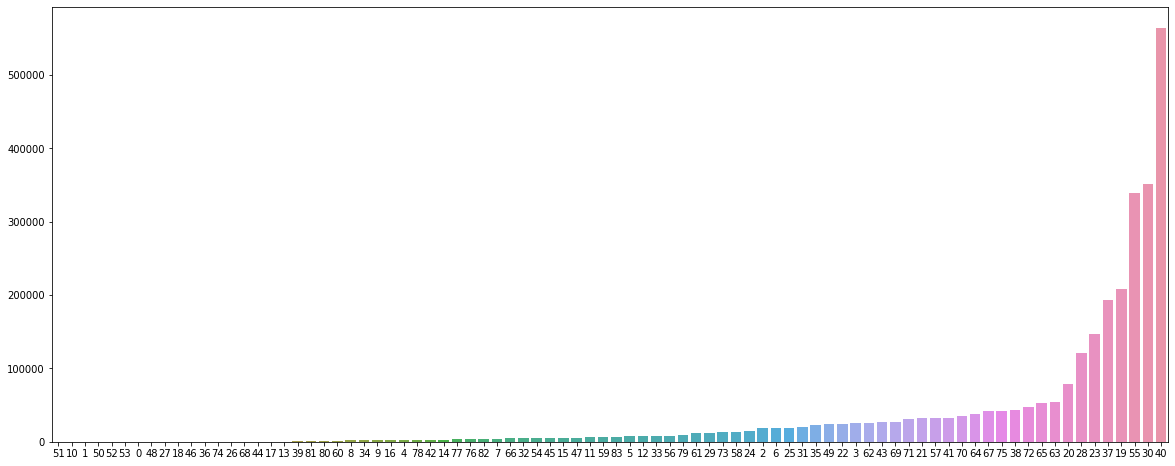

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(df.item_category_id.value_counts().sort_values().index, df.item_category_id.value_counts().sort_values().values, order=df.item_category_id.value_counts().sort_values().index)

In [ ]:
items_cat[items_cat["item_category_id"]==75]

item_category_name  item_category_id
75  Программы - Для дома и офиса                75

In [ ]:
df.groupby("date").mean("item")

In [ ]:
group = df.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

In [ ]:
combination

date_block_num  shop_id  item_id
0                      0       59    22154
1                      0       59     2552
2                      0       59     2554
3                      0       59     2555
4                      0       59     2564
...                  ...      ...      ...
10913845              33       21     7635
10913846              33       21     7638
10913847              33       21     7640
10913848              33       21     7632
10913849              33       21     7440

[10913850 rows x 3 columns]

In [ ]:
group

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean
0                     0        0       32             6.0            221.0
1                     0        0       33             3.0            347.0
2                     0        0       35             1.0            247.0
3                     0        0       43             1.0            221.0
4                     0        0       51             2.0            128.5
...                 ...      ...      ...             ...              ...
1609119              33       59    22087             6.0            119.0
1609120              33       59    22088             2.0            119.0
1609121              33       59    22091             1.0            179.0
1609122              33       59    22100             1.0            629.0
1609123              33       59    22102             1.0           1250.0

[1609124 rows x 5 columns]